# Import modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

In [83]:
df = pd.read_excel('Online Retail.xlsx')

In [102]:
import pandas as pd
import numpy as np

import time, warnings
import datetime as dt

#modules for predictive models
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
#from sklearn.mixture import GMM

from sklearn.metrics import silhouette_samples, silhouette_score

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")

In [103]:
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

# Prepare the Data

As customer clusters may vary by geography, I’ll restrict the data to only United Kingdom customers, which contains most of our customers historical data.

In [104]:
retail_uk = df[df['Country']=='United Kingdom']
#check the shape
retail_uk.shape

(495478, 8)

In [105]:
#remove canceled orders
retail_uk = retail_uk[retail_uk['Quantity']>0]
retail_uk.shape

(486286, 8)

In [106]:
#remove rows where customerID are NA
retail_uk.dropna(subset=['CustomerID'],how='all',inplace=True)
retail_uk.shape

(354345, 8)

In [107]:
retail_uk['InvoiceDate'].value_counts()

2011-11-14 15:27:00    542
2011-11-28 15:54:00    533
2011-12-05 17:17:00    529
2011-11-23 13:39:00    443
2011-10-31 14:09:00    435
                      ... 
2011-02-03 15:28:00      1
2011-07-29 15:25:00      1
2011-05-05 18:06:00      1
2011-02-15 15:41:00      1
2010-12-02 16:48:00      1
Name: InvoiceDate, Length: 15615, dtype: int64

In [108]:
#restrict the data to one full year because it's better to use a metric per Months or Years in RFM
retail_uk = retail_uk[retail_uk['InvoiceDate']>= "2010-12-09"]
retail_uk

InvoiceNo StockCode                          Description  Quantity  \
19632     537879     22114    HOT WATER BOTTLE TEA AND SYMPATHY        12   
19633     537879     22835      HOT WATER BOTTLE I AM SO POORLY         8   
19634     537879     85150        LADIES & GENTLEMEN METAL SIGN         6   
19635     537879     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS         4   
19636     537879     21524       DOORMAT SPOTTY HOME SWEET HOME         2   
...          ...       ...                                  ...       ...   
541889    581585     22466       FAIRY TALE COTTAGE NIGHT LIGHT        12   
541890    581586     22061  LARGE CAKE STAND  HANGING STRAWBERY         8   
541891    581586     23275     SET OF 3 HANGING OWLS OLLIE BEAK        24   
541892    581586     21217        RED RETROSPOT ROUND CAKE TINS        24   
541893    581586     20685                DOORMAT RED RETROSPOT        10   

               InvoiceDate  UnitPrice  CustomerID         Country  
19632  2010-12-09 08:34:00       3.95     14243.0  United Kingdom  
19633  2010-12-09 08:34:00       4.65     14243.0  United Kingdom  
19634  2010-12-09 08:34:00       2.55     14243.0  United Kingdom  
19635  2010-12-09 08:34:00       7.95     14243.0  United Kingdom  
19636  2010-12-09 08:34:00       7.95     14243.0  United Kingdom  
...                    ...        ...         ...             ...  
541889 2011-12-09 12:31:00       1.95     15804.0  United Kingdom  
541890 2011-12-09 12:49:00       2.95     13113.0  United Kingdom  
541891 2011-12-09 12:49:00       1.25     13113.0  United Kingdom  
541892 2011-12-09 12:49:00       8.95     13113.0  United Kingdom  
541893 2011-12-09 12:49:00       7.08     13113.0  United Kingdom  

[342478 rows x 8 columns]

In [109]:
print("Summary..")
#exploring the unique values of each attribute
print("Number of transactions: ", retail_uk['InvoiceNo'].nunique())
print("Number of products bought: ",retail_uk['StockCode'].nunique())
print("Number of customers:", retail_uk['CustomerID'].nunique() )
print("Percentage of customers NA: ", round(retail_uk['CustomerID'].isnull().sum() * 100 / len(df),2),"%" )

Summary..
Number of transactions:  16017
Number of products bought:  3611
Number of customers: 3863
Percentage of customers NA:  0.0 %


# RFM Analysis

RFM (**Recency, Frequency, Monetary**) analysis is a customer segmentation technique that uses past purchase **behavior** to divide customers into groups. <br> RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.
- RECENCY (R): Days since last purchase 
- FREQUENCY (F): Total number of purchases 
- MONETARY VALUE (M): Total money this customer spent.

We will create those 3 customer attributes for each customer.


## Recency


To calculate recency, we need to choose a date point from which we evaluate **how many days ago was the customer's last purchase**.

In [110]:
#last date available in our dataset
retail_uk['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

The last date we have is 2011-12-09 so we will use it as reference.

In [111]:
now = dt.date(2011,12,9)
print(now)

2011-12-09


In [112]:
#create a new column called date which contains the date of invoice only
retail_uk['date'] = retail_uk['InvoiceDate'].dt.date

In [113]:
retail_uk

InvoiceNo StockCode                          Description  Quantity  \
19632     537879     22114    HOT WATER BOTTLE TEA AND SYMPATHY        12   
19633     537879     22835      HOT WATER BOTTLE I AM SO POORLY         8   
19634     537879     85150        LADIES & GENTLEMEN METAL SIGN         6   
19635     537879     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS         4   
19636     537879     21524       DOORMAT SPOTTY HOME SWEET HOME         2   
...          ...       ...                                  ...       ...   
541889    581585     22466       FAIRY TALE COTTAGE NIGHT LIGHT        12   
541890    581586     22061  LARGE CAKE STAND  HANGING STRAWBERY         8   
541891    581586     23275     SET OF 3 HANGING OWLS OLLIE BEAK        24   
541892    581586     21217        RED RETROSPOT ROUND CAKE TINS        24   
541893    581586     20685                DOORMAT RED RETROSPOT        10   

               InvoiceDate  UnitPrice  CustomerID         Country        date  
19632  2010-12-09 08:34:00       3.95     14243.0  United Kingdom  2010-12-09  
19633  2010-12-09 08:34:00       4.65     14243.0  United Kingdom  2010-12-09  
19634  2010-12-09 08:34:00       2.55     14243.0  United Kingdom  2010-12-09  
19635  2010-12-09 08:34:00       7.95     14243.0  United Kingdom  2010-12-09  
19636  2010-12-09 08:34:00       7.95     14243.0  United Kingdom  2010-12-09  
...                    ...        ...         ...             ...         ...  
541889 2011-12-09 12:31:00       1.95     15804.0  United Kingdom  2011-12-09  
541890 2011-12-09 12:49:00       2.95     13113.0  United Kingdom  2011-12-09  
541891 2011-12-09 12:49:00       1.25     13113.0  United Kingdom  2011-12-09  
541892 2011-12-09 12:49:00       8.95     13113.0  United Kingdom  2011-12-09  
541893 2011-12-09 12:49:00       7.08     13113.0  United Kingdom  2011-12-09  

[342478 rows x 9 columns]

In [114]:
#group by customers and check last date of purchase
recency_df = retail_uk.groupby(by='CustomerID', as_index=False).agg({'date':max})
recency_df.columns = ['CustomerID','LastPurchaseDate']
recency_df

CustomerID LastPurchaseDate
0        12346.0       2011-01-18
1        12747.0       2011-12-07
2        12748.0       2011-12-09
3        12749.0       2011-12-06
4        12820.0       2011-12-06
...          ...              ...
3858     18280.0       2011-03-07
3859     18281.0       2011-06-12
3860     18282.0       2011-12-02
3861     18283.0       2011-12-06
3862     18287.0       2011-10-28

[3863 rows x 2 columns]

In [115]:
recency_df['Recency']=now-recency_df['LastPurchaseDate']

In [116]:
recency_df

CustomerID LastPurchaseDate  Recency
0        12346.0       2011-01-18 325 days
1        12747.0       2011-12-07   2 days
2        12748.0       2011-12-09   0 days
3        12749.0       2011-12-06   3 days
4        12820.0       2011-12-06   3 days
...          ...              ...      ...
3858     18280.0       2011-03-07 277 days
3859     18281.0       2011-06-12 180 days
3860     18282.0       2011-12-02   7 days
3861     18283.0       2011-12-06   3 days
3862     18287.0       2011-10-28  42 days

[3863 rows x 3 columns]

In [117]:
#calculate recency
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x: (now - x).days)

In [118]:
recency_df.head()

CustomerID LastPurchaseDate  Recency
0     12346.0       2011-01-18      325
1     12747.0       2011-12-07        2
2     12748.0       2011-12-09        0
3     12749.0       2011-12-06        3
4     12820.0       2011-12-06        3

In [119]:
#drop LastPurchaseDate as we don't need it anymore
recency_df.drop('LastPurchaseDate',axis=1,inplace=True)

Now we have the recency attribute created. e.g: Customer with ID = 12346 did his/her last purshace 325 days ago.

## Frequency

Frequency helps us to know **how many times a customer purchased from us**. To do that we need to check how many invoices are registered by the same customer.

In [120]:
# drop duplicates
retail_uk_copy = retail_uk
retail_uk_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
retail_uk_copy 
# calculate frequency of purchases
frequency_df = retail_uk_copy.groupby(by=['CustomerID'], as_index=False).agg({'InvoiceNo':'count'})
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

CustomerID  Frequency
0     12346.0          1
1     12747.0         10
2     12748.0        196
3     12749.0          5
4     12820.0          4

## Monetary

Monetary attribute answers the question: **How much money did the customer spent over time?**

To do that, first, we will create a new column total cost to have the total price per invoice.

In [121]:
retail_uk

InvoiceNo StockCode                          Description  Quantity  \
19632     537879     22114    HOT WATER BOTTLE TEA AND SYMPATHY        12   
19640     537880     21669      BLUE STRIPE CERAMIC DRAWER KNOB        12   
19656     537881     22730           ALARM CLOCK BAKELIKE IVORY        16   
19668     537882     22804      CANDLEHOLDER PINK HANGING HEART        32   
19672     537883     84946      ANTIQUE SILVER TEA GLASS ETCHED        12   
...          ...       ...                                  ...       ...   
541863    581582     23552         BICYCLE PUNCTURE REPAIR KIT          6   
541865    581583     20725              LUNCH BAG RED RETROSPOT        40   
541867    581584     20832     RED FLOCK LOVE HEART PHOTO FRAME        72   
541869    581585     22481       BLACK TEA TOWEL CLASSIC DESIGN        12   
541890    581586     22061  LARGE CAKE STAND  HANGING STRAWBERY         8   

               InvoiceDate  UnitPrice  CustomerID         Country        date  
19632  2010-12-09 08:34:00       3.95     14243.0  United Kingdom  2010-12-09  
19640  2010-12-09 09:14:00       1.25     12963.0  United Kingdom  2010-12-09  
19656  2010-12-09 09:23:00       3.75     15513.0  United Kingdom  2010-12-09  
19668  2010-12-09 09:25:00       2.55     15079.0  United Kingdom  2010-12-09  
19672  2010-12-09 09:27:00       1.25     14437.0  United Kingdom  2010-12-09  
...                    ...        ...         ...             ...         ...  
541863 2011-12-09 12:21:00       2.08     17581.0  United Kingdom  2011-12-09  
541865 2011-12-09 12:23:00       1.45     13777.0  United Kingdom  2011-12-09  
541867 2011-12-09 12:25:00       0.72     13777.0  United Kingdom  2011-12-09  
541869 2011-12-09 12:31:00       0.39     15804.0  United Kingdom  2011-12-09  
541890 2011-12-09 12:49:00       2.95     13113.0  United Kingdom  2011-12-09  

[16017 rows x 9 columns]

In [122]:
#create column total cost
retail_uk['TotalCost'] = retail_uk['Quantity'] * retail_uk['UnitPrice']
retail_uk

InvoiceNo StockCode                          Description  Quantity  \
19632     537879     22114    HOT WATER BOTTLE TEA AND SYMPATHY        12   
19640     537880     21669      BLUE STRIPE CERAMIC DRAWER KNOB        12   
19656     537881     22730           ALARM CLOCK BAKELIKE IVORY        16   
19668     537882     22804      CANDLEHOLDER PINK HANGING HEART        32   
19672     537883     84946      ANTIQUE SILVER TEA GLASS ETCHED        12   
...          ...       ...                                  ...       ...   
541863    581582     23552         BICYCLE PUNCTURE REPAIR KIT          6   
541865    581583     20725              LUNCH BAG RED RETROSPOT        40   
541867    581584     20832     RED FLOCK LOVE HEART PHOTO FRAME        72   
541869    581585     22481       BLACK TEA TOWEL CLASSIC DESIGN        12   
541890    581586     22061  LARGE CAKE STAND  HANGING STRAWBERY         8   

               InvoiceDate  UnitPrice  CustomerID         Country        date  \
19632  2010-12-09 08:34:00       3.95     14243.0  United Kingdom  2010-12-09   
19640  2010-12-09 09:14:00       1.25     12963.0  United Kingdom  2010-12-09   
19656  2010-12-09 09:23:00       3.75     15513.0  United Kingdom  2010-12-09   
19668  2010-12-09 09:25:00       2.55     15079.0  United Kingdom  2010-12-09   
19672  2010-12-09 09:27:00       1.25     14437.0  United Kingdom  2010-12-09   
...                    ...        ...         ...             ...         ...   
541863 2011-12-09 12:21:00       2.08     17581.0  United Kingdom  2011-12-09   
541865 2011-12-09 12:23:00       1.45     13777.0  United Kingdom  2011-12-09   
541867 2011-12-09 12:25:00       0.72     13777.0  United Kingdom  2011-12-09   
541869 2011-12-09 12:31:00       0.39     15804.0  United Kingdom  2011-12-09   
541890 2011-12-09 12:49:00       2.95     13113.0  United Kingdom  2011-12-09   

        TotalCost  
19632       47.40  
19640       15.00  
19656       60.00  
19668       81.60  
19672       15.00  
...           ...  
541863      12.48  
541865      58.00  
541867      51.84  
541869       4.68  
541890      23.60  

[16017 rows x 10 columns]

In [123]:
monetary_df = retail_uk.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

CustomerID  Monetary
0     12346.0  77183.60
1     12747.0    658.89
2     12748.0   3739.23
3     12749.0     98.35
4     12820.0     58.20

## Create RFM Table

In [124]:
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='CustomerID')
temp_df.head()

CustomerID  Recency  Frequency
0     12346.0      325          1
1     12747.0        2         10
2     12748.0        0        196
3     12749.0        3          5
4     12820.0        3          4

In [125]:
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='CustomerID')
#use CustomerID as index
rfm_df.set_index('CustomerID',inplace=True)
#check the head
rfm_df

Recency  Frequency  Monetary
CustomerID                              
12346.0         325          1  77183.60
12747.0           2         10    658.89
12748.0           0        196   3739.23
12749.0           3          5     98.35
12820.0           3          4     58.20
...             ...        ...       ...
18280.0         277          1     23.70
18281.0         180          1      5.04
18282.0           7          2     38.25
18283.0           3         16     66.75
18287.0          42          3     80.40

[3863 rows x 3 columns]

Customer with ID = 12346 has recency: 325 days, frequency:1, and monetary: 77183,60 £.

### RFM Table Correctness verification

In [50]:
retail_uk[retail_uk['CustomerID']==12346.0]

InvoiceNo StockCode                     Description  Quantity  \
61619    541431     23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   

              InvoiceDate  UnitPrice  CustomerID         Country        date  \
61619 2011-01-18 10:01:00       1.04     12346.0  United Kingdom  2011-01-18   

       TotalCost  
61619    77183.6

In [51]:
(now - dt.date(2011,1,18)).days == 325

True

As we can see our RFM table is correct. The first customer bought only once, and only one product with huge amount. 

## Customer segments with RFM Model

Before moving to customer segments, Let's see the application of Pareto Principle – commonly referred to as the 80-20 rule on our dataset by applying it to our RFM variables.

Pareto’s rule says **80% of the results come from 20% of the causes**.

Similarly, **20% customers contribute to 80% of your total revenue**. Let's verify that because that will help us know which customers to focus on when marketing new products.

### Applying 80-20 rule

In [53]:
#get the 80% of the revenue
pareto_cutoff = rfm_df['Monetary'].sum() * 0.8
print("The 80% of total revenue is: ",round(pareto_cutoff,2))

The 80% of total revenue is:  890679.54


In [126]:
customers_rank = rfm_df
# Create a new column that is the rank of the value of coverage in descending order
customers_rank['Rank'] = customers_rank['Monetary'].rank(ascending=0)
#customers_rank.drop('RevenueRank',axis=1,inplace=True)
customers_rank.head()

Recency  Frequency  Monetary    Rank
CustomerID                                      
12346.0         325          1  77183.60     2.0
12747.0           2         10    658.89   183.0
12748.0           0        196   3739.23    34.0
12749.0           3          5     98.35  1140.0
12820.0           3          4     58.20  1665.5

### Top Customers

In [127]:
customers_rank.sort_values('Rank',ascending=True)

Recency  Frequency   Monetary    Rank
CustomerID                                       
16446.0           0          2  168471.25     1.0
12346.0         325          1   77183.60     2.0
15098.0         182          3   39916.50     3.0
18102.0           0         57   39646.45     4.0
17949.0           1         44   28685.69     5.0
...             ...        ...        ...     ...
15503.0         362          1       0.42  3859.5
15645.0          18          1       0.42  3859.5
17914.0           3          1       0.39  3861.5
13271.0          37          1       0.39  3861.5
13256.0          14          1       0.00  3863.0

[3863 rows x 4 columns]

In [128]:
#get top 20% of the customers
top_20_cutoff = 3863 *20 /100
top_20_cutoff

772.6

In [129]:
#sum the monetary values over the customer with rank <=773
revenueByTop20 = customers_rank[customers_rank['Rank'] <= 772]['Monetary'].sum()
revenueByTop20

976683.3499999999

In our case, the 80% of total revenue is not achieved by the 20% of TOP customers but approximately, it does, because they are less than our 20% TOP customers who achieve it. It would be interesting to study this group of customers because they are those who make our most revenue.

### Applying RFM score formula

The simplest way to create customers segments from RFM Model is to use **Quartiles**. We assign a score from 1 to 4 to Recency, Frequency and Monetary. Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

Note: Quintiles (score from 1-5) offer better granularity, in case the business needs that but it will be more challenging to create segments since we will have 5*5*5 possible combinations. So, we will use quartiles.

#### RFM Quartiles

In [130]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])

In [131]:
quantiles

Recency  Frequency  Monetary    Rank
0.25     17.0        1.0      17.4   966.5
0.50     49.0        2.0      45.0  1930.5
0.75    134.0        5.0     121.6  2898.0

In [132]:
d=quantiles.to_dict()
d

{'Recency': {0.25: 17.0, 0.5: 49.0, 0.75: 134.0},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 17.4, 0.5: 45.0, 0.75: 121.6},
 'Rank': {0.25: 966.5, 0.5: 1930.5, 0.75: 2898.0}}

#### Creation of RFM segmentation table

We will create two segmentation classes since, high recency is bad, while high frequency and monetary value is good.

In [133]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [139]:
#create rfm segmentation table
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore,args=('Recency',quantiles))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles))

In [140]:
rfm_segmentation.head()

Recency  Frequency  Monetary    Rank  R_Quartile  F_Quartile  \
CustomerID                                                                 
12346.0         325          1  77183.60     2.0           1           1   
12747.0           2         10    658.89   183.0           4           4   
12748.0           0        196   3739.23    34.0           4           4   
12749.0           3          5     98.35  1140.0           4           3   
12820.0           3          4     58.20  1665.5           4           3   

            M_Quartile  
CustomerID              
12346.0              4  
12747.0              4  
12748.0              4  
12749.0              3  
12820.0              3

Now that we have the score of each customer, we can represent our customer segmentation.<br>
First, we need to combine the scores (R_Quartile, F_Quartile,M_Quartile) together.

In [144]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

Recency  Frequency  Monetary    Rank  R_Quartile  F_Quartile  \
CustomerID                                                                 
12346.0         325          1  77183.60     2.0           1           1   
12747.0           2         10    658.89   183.0           4           4   
12748.0           0        196   3739.23    34.0           4           4   
12749.0           3          5     98.35  1140.0           4           3   
12820.0           3          4     58.20  1665.5           4           3   

            M_Quartile RFMScore  
CustomerID                       
12346.0              4      114  
12747.0              4      444  
12748.0              4      444  
12749.0              3      433  
12820.0              3      433

Best Recency score = 4: most recently purchase.
Best Frequency score = 4: most quantity purchase.
Best Monetary score = 4: spent the most.

Let's see who are our **Champions** (best customers).

In [145]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('Monetary', ascending=False).head(10)

Recency  Frequency  Monetary  Rank  R_Quartile  F_Quartile  \
CustomerID                                                               
18102.0           0         57  39646.45   4.0           4           4   
17949.0           1         44  28685.69   5.0           4           4   
17450.0           8         44  25953.51   6.0           4           4   
16013.0           3         45  17163.28   8.0           4           4   
16333.0           7         22  14418.96   9.0           4           4   
15769.0           7         25  11660.84  11.0           4           4   
12901.0           8         28   9230.45  12.0           4           4   
13798.0           1         56   7786.26  13.0           4           4   
16684.0           4         28   7700.08  14.0           4           4   
17857.0           4         23   7655.18  15.0           4           4   

            M_Quartile RFMScore  
CustomerID                       
18102.0              4      444  
17949.0              4      444  
17450.0              4      444  
16013.0              4      444  
16333.0              4      444  
15769.0              4      444  
12901.0              4      444  
13798.0              4      444  
16684.0              4      444  
17857.0              4      444

We can find [here](http://www.blastam.com/blog/rfm-analysis-boosts-sales) a suggestion of key segments and then we can decide which segment to consider for further study.

**Note:** the suggested link use the opposite valuation: 1 as highest/best score and 4 is the lowest.

**How many customers do we have in each segment?**

In [146]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

Best Customers:  356
Loyal Customers:  752
Big Spenders:  966
Almost Lost:  64
Lost Customers:  9
Lost Cheap Customers:  353


Now that we knew our customers segments we can choose how to target or deal with each segment.

For example:

**Best Customers - Champions**: Reward them. They can be early adopters to new products. Suggest them "Refer a friend".

**At Risk**: Send them personalized emails to encourage them to shop.

More ideas about what actions to perform in [Ometria](http://54.73.114.30/customer-segmentation#).

### Conclusion - perspective from this level of customer segmentation
To gain even further insight into customer behavior, we can dig deeper in the relationship between RFM variables.  

RFM model can be used in conjunction with certain predictive models like **k-means clustering**, **Logistic Regression** and **Recommendation** to produce better informative results on customer behavior.

We will go for k-means since it has been widely used for Market Segmentation and it offers the advantage of being simple to implement, following Andrew Ng who advice in his Machine Learning course, start with a dirty and simple model then move to more complex models because simple implementation helps having a first glance at the data and know where/how to exploit it better.

## Applying K-means clustering on RFM variables

### Preprocess Data

In [148]:
rfm_data = rfm_df.drop(['R_Quartile','F_Quartile','M_Quartile','RFMScore','Rank'],axis=1)
rfm_data.head()

Recency  Frequency  Monetary
CustomerID                              
12346.0         325          1  77183.60
12747.0           2         10    658.89
12748.0           0        196   3739.23
12749.0           3          5     98.35
12820.0           3          4     58.20

#### Feature correlations

In [149]:
rfm_data.corr()

Recency  Frequency  Monetary
Recency    1.000000  -0.279236 -0.027727
Frequency -0.279236   1.000000  0.156431
Monetary  -0.027727   0.156431  1.000000

In [150]:
import seaborn as sns

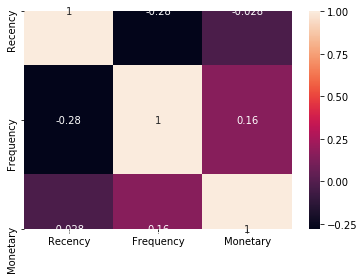

In [152]:
sns.heatmap(rfm_data.corr(),annot=True)

On one hand, we have a negative correlation between:
- Recency and Frequency
- Recency and Monetary

On the other hand, the correlation between **Monetary and Frequency** is positive comparing to negative ones but still not that strong. 

#### Visualize feature distributions

To get a better understanding of the dataset, we can construct a scatter matrix of each of the three features present in the RFM data. 

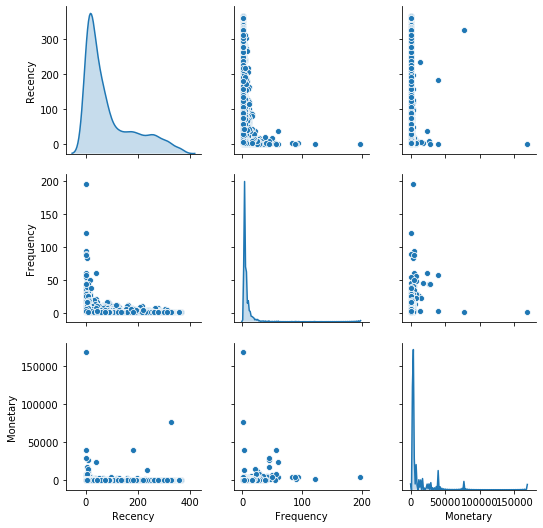

In [154]:
import seaborn as sns
sns.pairplot(rfm_data,diag_kind='kde')
plt.show()

We can notice that we have a **skewed distribution** of the 3 variables and there exist **outliers**.

This indicates how normalization is required to make the data features normally distributed as **clustering** algorithms **require** them to be **normally distributed**.

#### Data Normalization

In [155]:
#log transformation
rfm_r_log = np.log(rfm_data['Recency']+0.1) #can't take log(0) and so add a small number
rfm_f_log = np.log(rfm_data['Frequency'])
rfm_m_log = np.log(rfm_data['Monetary']+0.1)

In [156]:
rfm_f_log

CustomerID
12346.0    0.000000
12747.0    2.302585
12748.0    5.278115
12749.0    1.609438
12820.0    1.386294
             ...   
18280.0    0.000000
18281.0    0.000000
18282.0    0.693147
18283.0    2.772589
18287.0    1.098612
Name: Frequency, Length: 3863, dtype: float64

In [157]:
log_data = pd.DataFrame({'Monetary': rfm_m_log,'Recency': rfm_r_log,'Frequency': rfm_f_log})

In [158]:
log_data.head()

Monetary   Recency  Frequency
CustomerID                                
12346.0     11.253944  5.784133   0.000000
12747.0      6.490708  0.741937   2.302585
12748.0      8.226662 -2.302585   5.278115
12749.0      4.589549  1.131402   1.609438
12820.0      4.065602  1.131402   1.386294

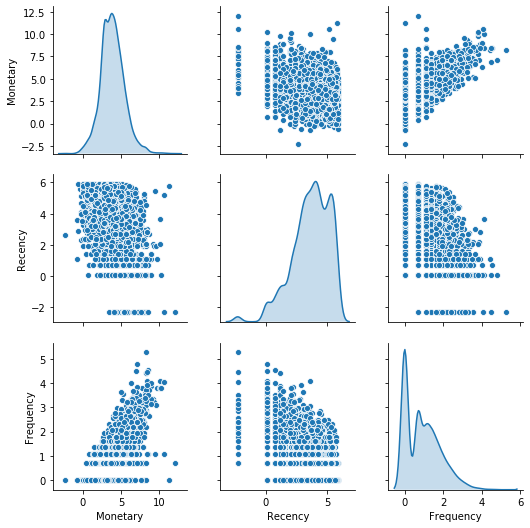

In [159]:
# Produce a scatter matrix for each pair of features in the data
sns.pairplot(log_data,diag_kind='kde');

The distributions of Frequency and Monetary are better, more normalized, but it's not the case with Recency Distribution, which is improved but not as much. 

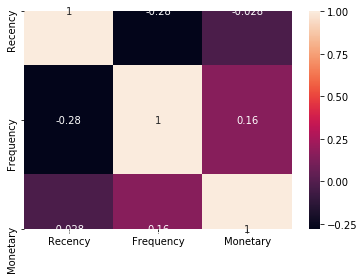

In [160]:
sns.heatmap(rfm_data.corr(),annot=True)

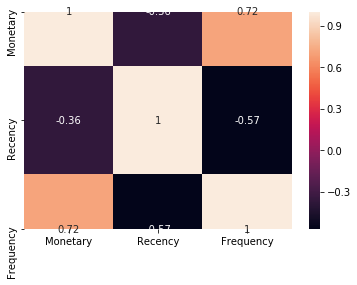

In [161]:
sns.heatmap(log_data.corr(),annot=True)

In [162]:
log_data.corr()

Monetary   Recency  Frequency
Monetary   1.000000 -0.364351   0.715609
Recency   -0.364351  1.000000  -0.569951
Frequency  0.715609 -0.569951   1.000000

Now, Monetary and Frequency are more strongly correlated.

### K-means Implementation

A common challenge with k-means is that you must tell it how many clusters you expect. Figuring out how many clusters we need is not obvious from data, thus we will try different clusters numbers and check their [silhouette coefficient](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html). The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). The [elbow](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_elbow_method) method can be used to determine the number of clusters as well.

**Note:** K-means is sensitive to initializations because those initializations are critical to quality of optima found. Thus, we will use smart initialization called ***k-means++***.

In [164]:
X=log_data

In [166]:
from sklearn.cluster import KMeans
# Let us check optimal number of clusters-
cluster_range = range( 1, 15)
cluster_errors = []
cluster_sil_scores = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 100,init='k-means++',random_state=0)
  clusters.fit(X)
  labels = clusters.labels_                     # capture the cluster lables
  centroids = clusters.cluster_centers_         # capture the centroids
  cluster_errors.append( clusters.inertia_ )    # capture the intertia
# combine the cluster_range and cluster_errors into a dataframe by combining them
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors} )
clusters_df

num_clusters  cluster_errors
0              1    20854.471710
1              2    11734.344017
2              3     9105.144985
3              4     7378.487449
4              5     6357.427789
5              6     5515.031876
6              7     4882.092384
7              8     4455.325180
8              9     4075.211027
9             10     3739.839516
10            11     3488.292169
11            12     3267.242262
12            13     3073.247468
13            14     2893.886024

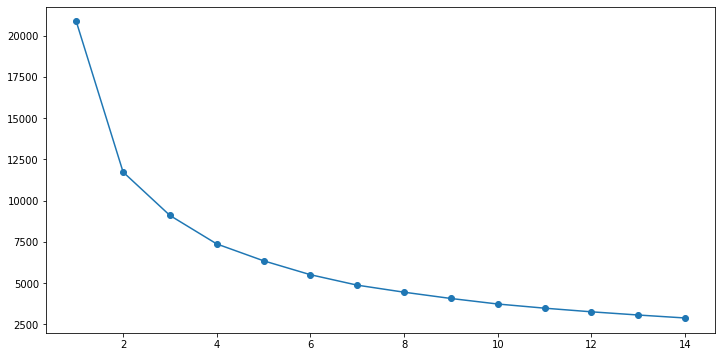

In [167]:
# Elbow plot
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [168]:
# Number of clusters
kmeans = KMeans(n_clusters=2,n_init = 100,init='k-means++',random_state=0)
# Fitting the input data
kmeans = kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_
# Comparing with scikit-learn centroids
print("Centroid values")
print("sklearn")
print(centroids) 
kmeans.labels_
kmeans.inertia_
# From sci-kit learn

Centroid values
sklearn
[[3.059406   4.46558978 0.40667582]
 [5.13581088 2.51322798 1.72752827]]


11734.344016707171

In [175]:
X['labels']=kmeans.labels_
X

Monetary   Recency  Frequency  labels
CustomerID                                        
12346.0     11.253944  5.784133   0.000000       1
12747.0      6.490708  0.741937   2.302585       1
12748.0      8.226662 -2.302585   5.278115       1
12749.0      4.589549  1.131402   1.609438       1
12820.0      4.065602  1.131402   1.386294       1
...               ...       ...        ...     ...
18280.0      3.169686  5.624378   0.000000       0
18281.0      1.637053  5.193512   0.000000       0
18282.0      3.646755  1.960095   0.693147       1
18283.0      4.202451  1.131402   2.772589       1
18287.0      4.388257  3.740048   1.098612       1

[3863 rows x 4 columns]

In [178]:
X0=X[X['labels']==0]
X1=X[X['labels']==1]

In [179]:
df=pd.concat([X0,X1])

In [180]:
df

Monetary   Recency  Frequency  labels
CustomerID                                       
12821.0     2.996732  5.366443   0.000000       0
12822.0     3.430756  4.249923   0.693147       0
12824.0     1.637053  4.079231   0.000000       0
12829.0     4.563306  5.817409   0.693147       0
12831.0     3.535145  5.568726   0.000000       0
...              ...       ...        ...     ...
18272.0     4.362079  0.741937   1.791759       1
18273.0     5.318610  0.741937   1.098612       1
18282.0     3.646755  1.960095   0.693147       1
18283.0     4.202451  1.131402   2.772589       1
18287.0     4.388257  3.740048   1.098612       1

[3863 rows x 4 columns]

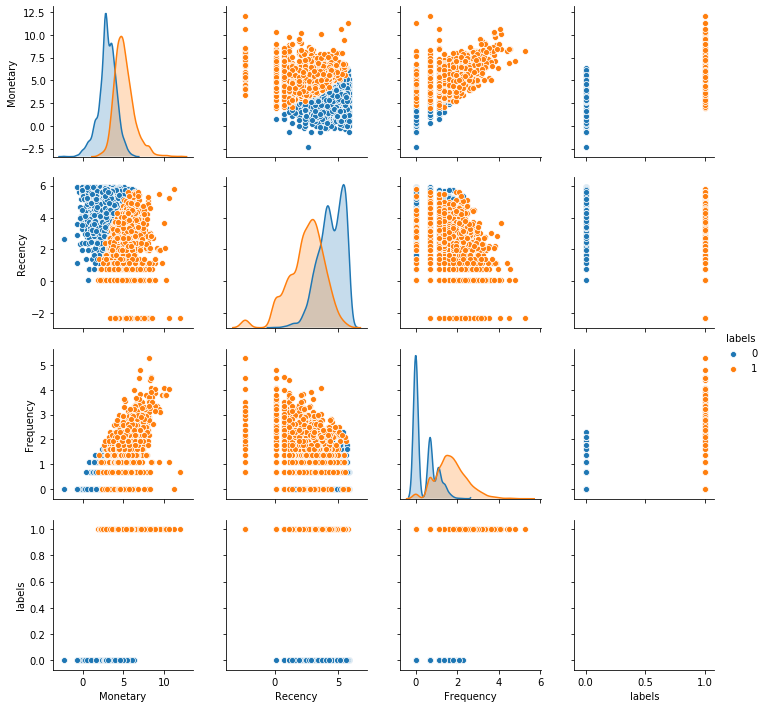

In [123]:
sns.pairplot(df,diag_kind='kde',hue='labels')

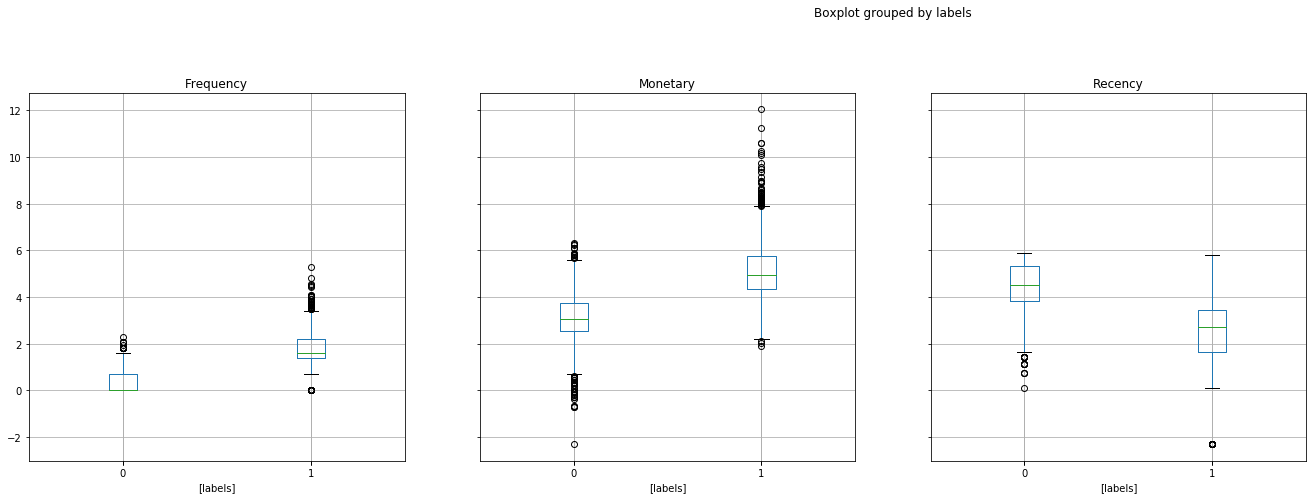

In [183]:
df.boxplot(by = 'labels',layout=(2,4), figsize=(30, 15))
plt.show()

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.3894055410198746
For n_clusters = 3 The average silhouette_score is : 0.30380548886125996
For n_clusters = 4 The average silhouette_score is : 0.3097934824953256
For n_clusters = 5 The average silhouette_score is : 0.2896155709937984
For n_clusters = 6 The average silhouette_score is : 0.29542754141440425
For n_clusters = 7 The average silhouette_score is : 0.291290144968737
For n_clusters = 8 The average silhouette_score is : 0.2908346836585755
For n_clusters = 9 The average silhouette_score is : 0.2941448434642242
For n_clusters = 10 The average silhouette_score is : 0.29784911416829085
For n_clusters = 11 The average silhouette_score is : 0.2926821667512021
For n_clusters = 12 The average silhouette_score is : 0.28817387884428447
For n_clusters = 13 The average silhouette_score is : 0.29217819065188305
For n_clusters = 14 The average silhouette_score is : 0.2959536

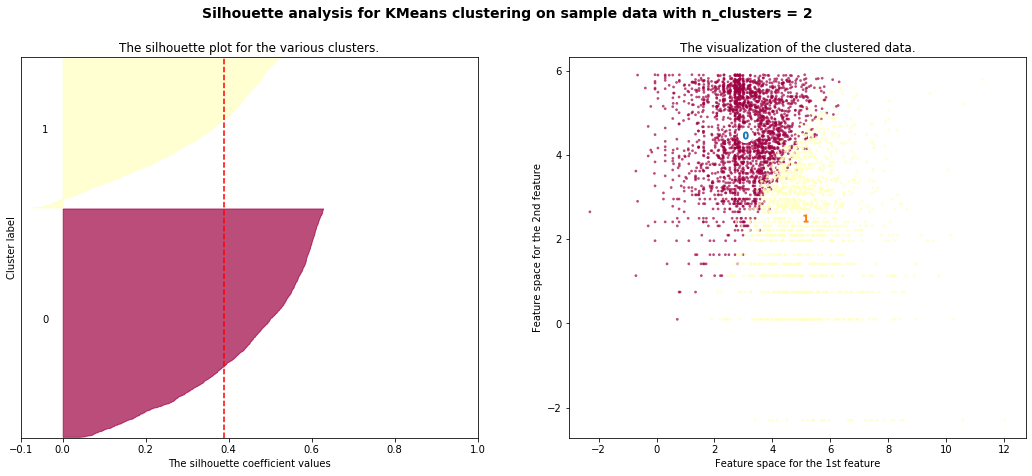

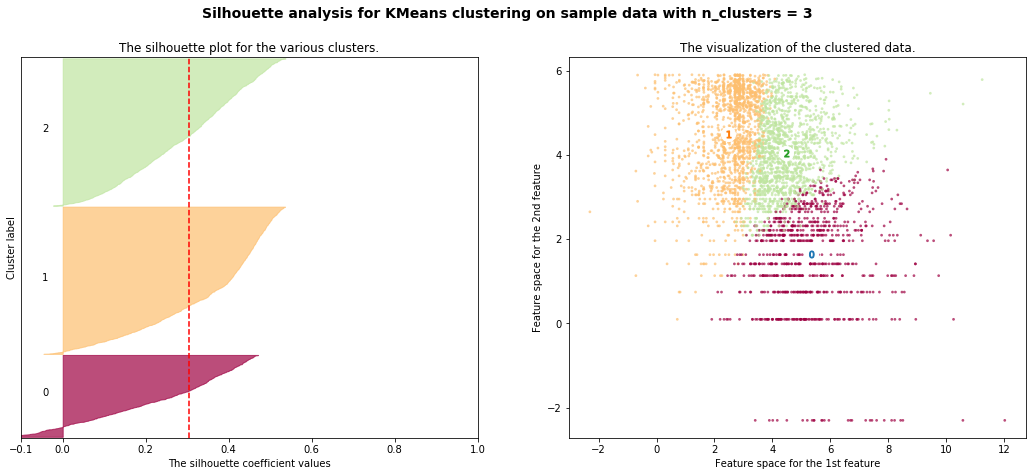

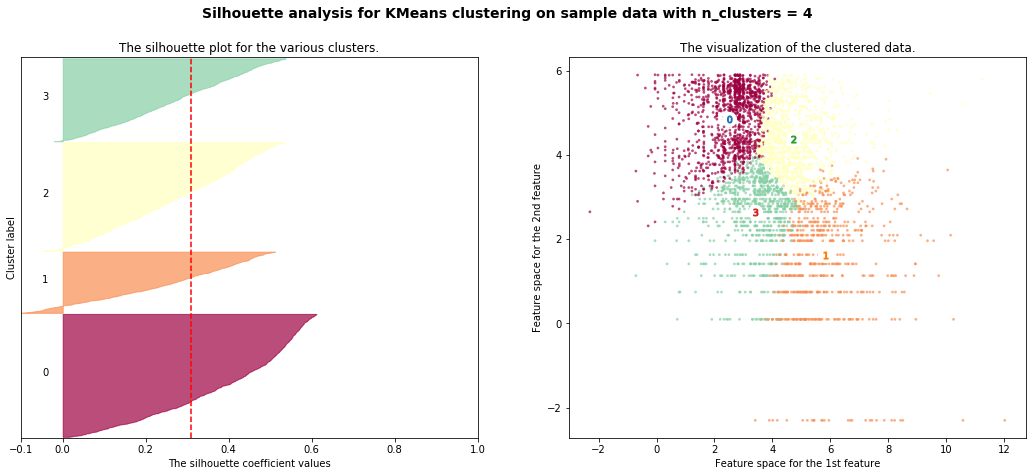

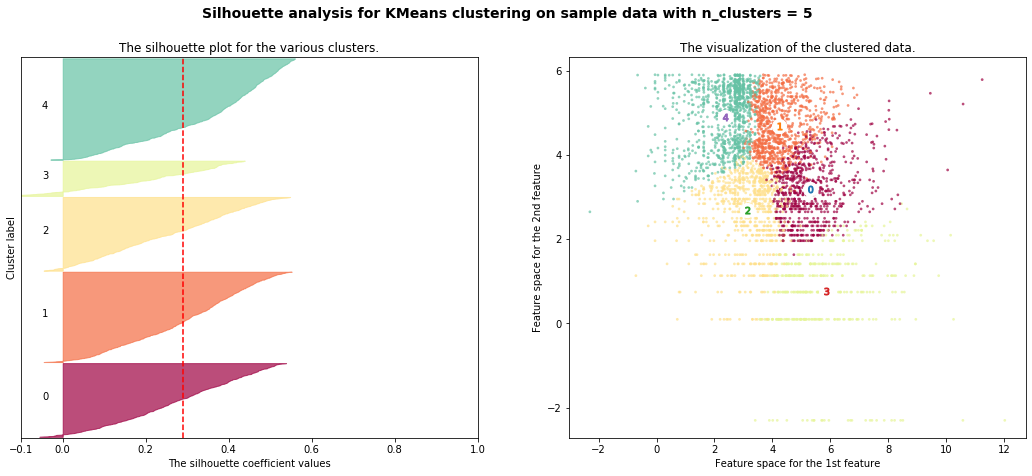

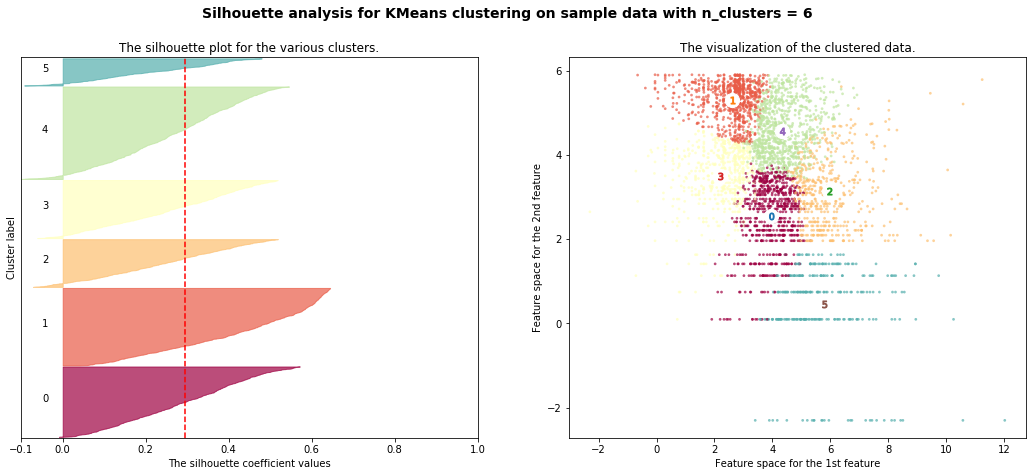

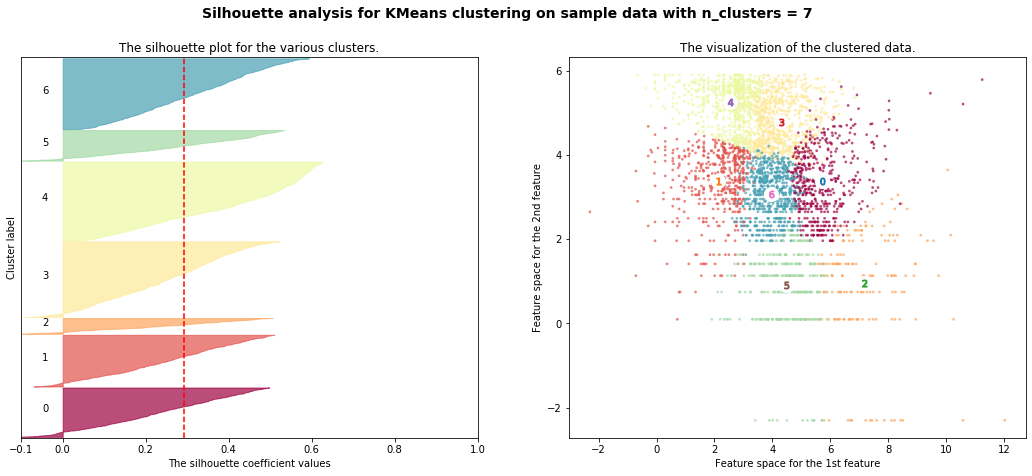

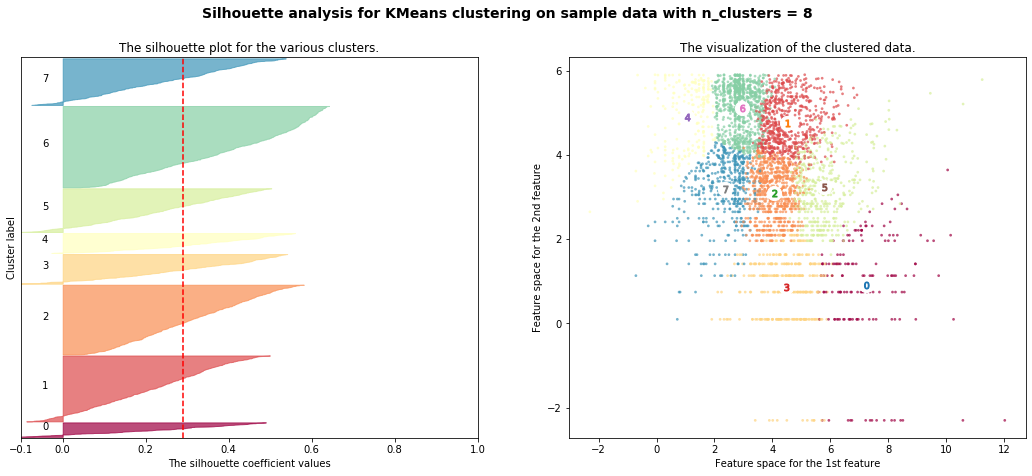

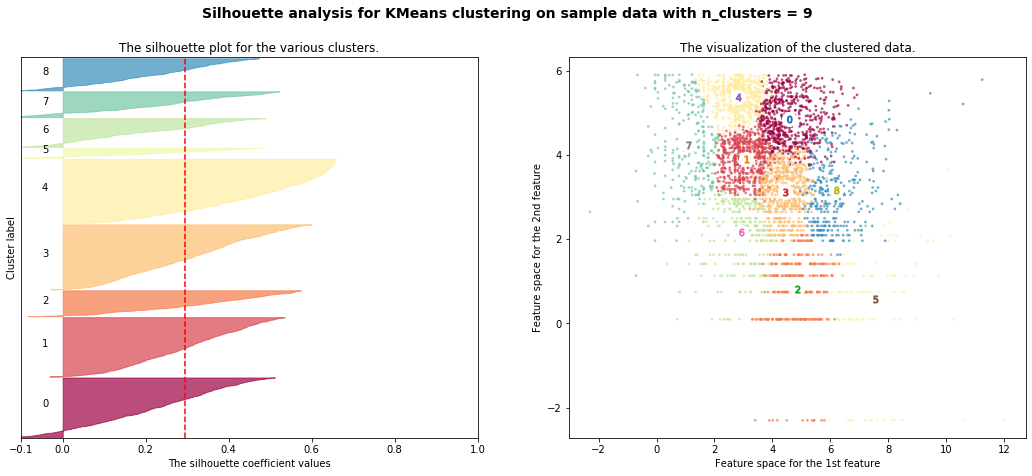

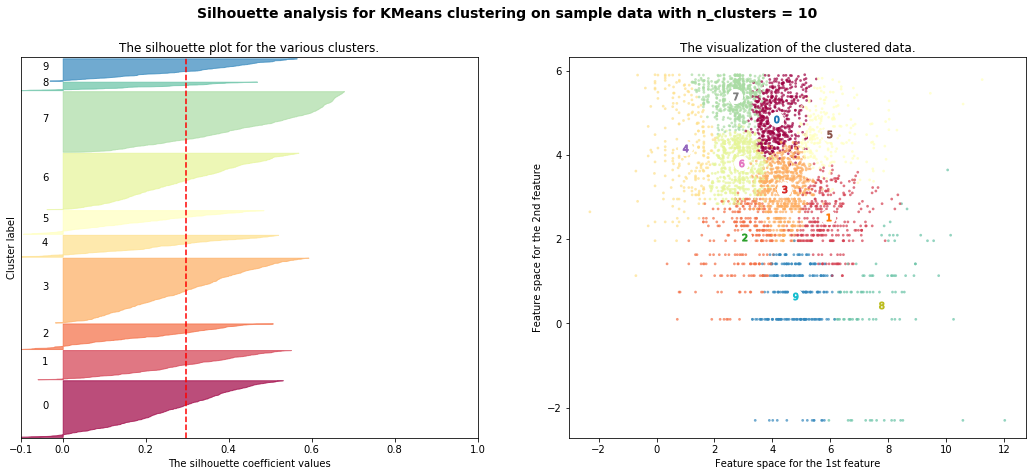

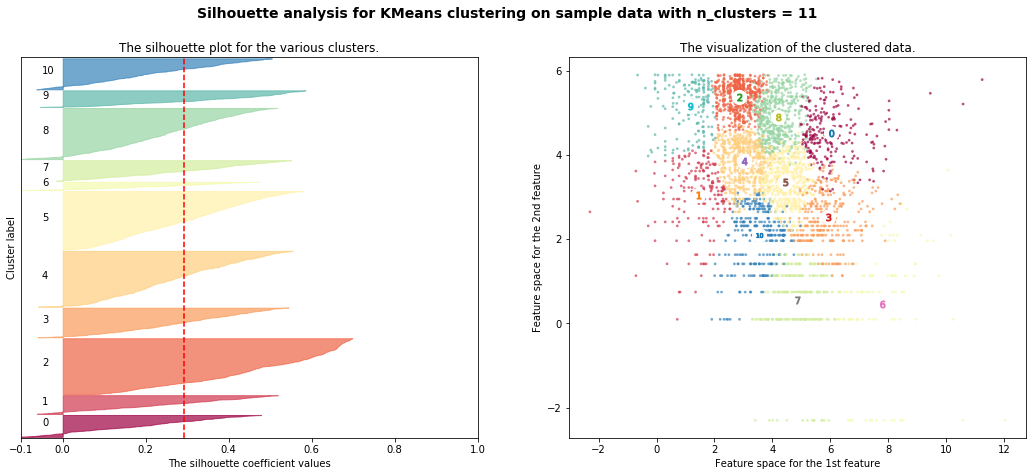

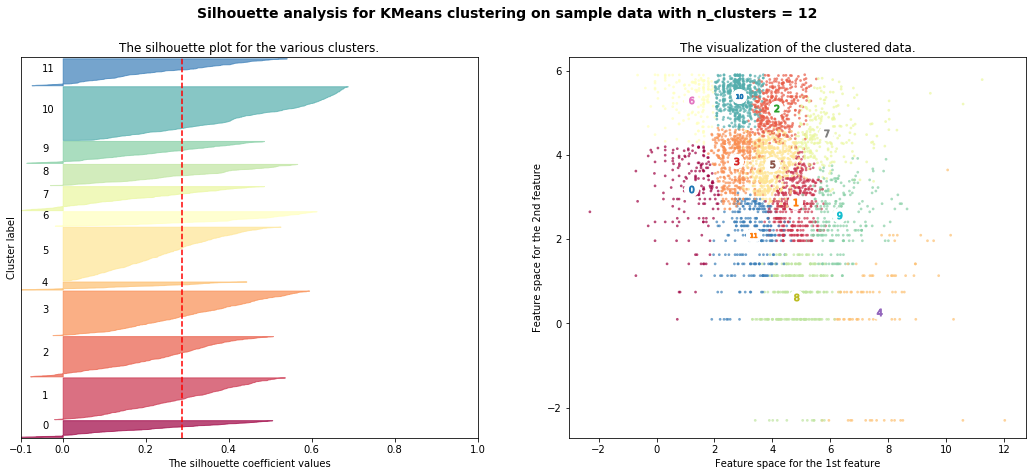

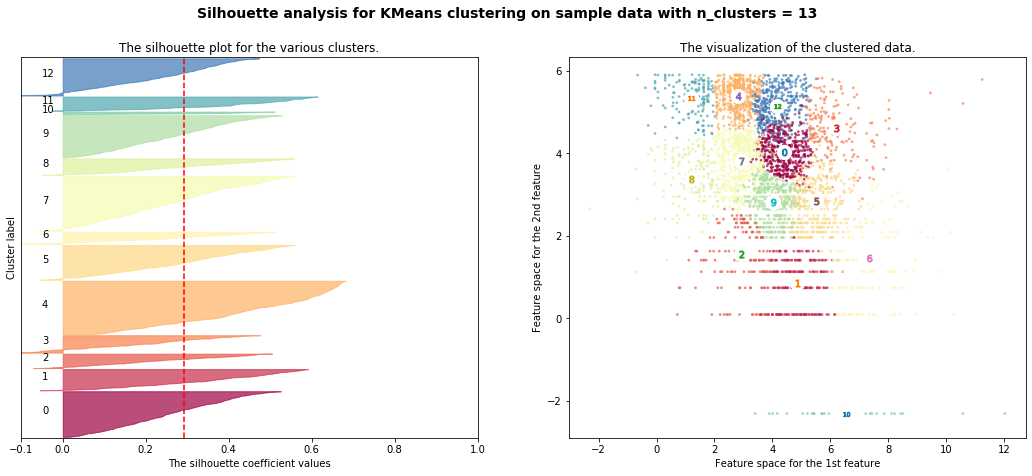

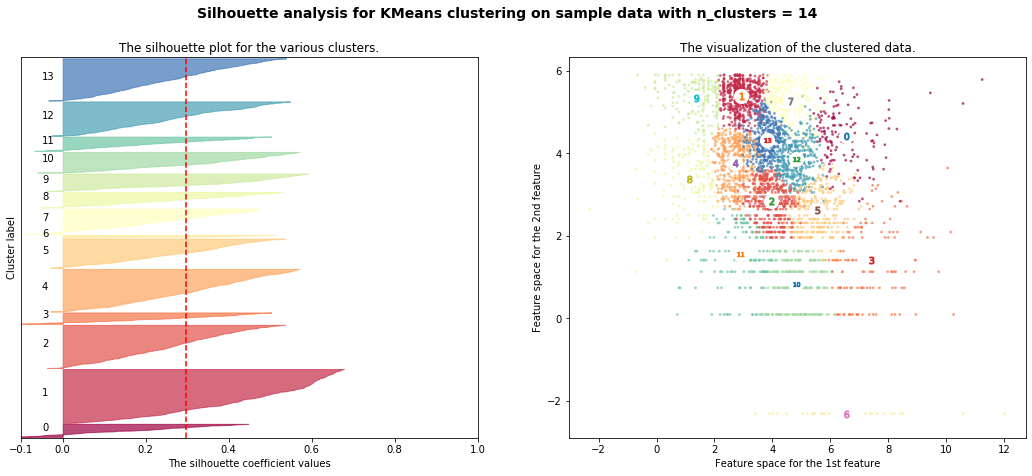

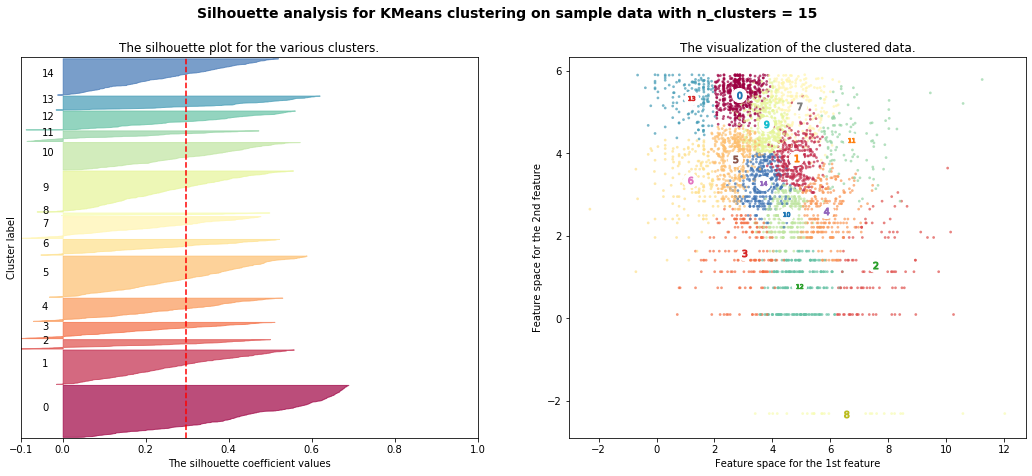

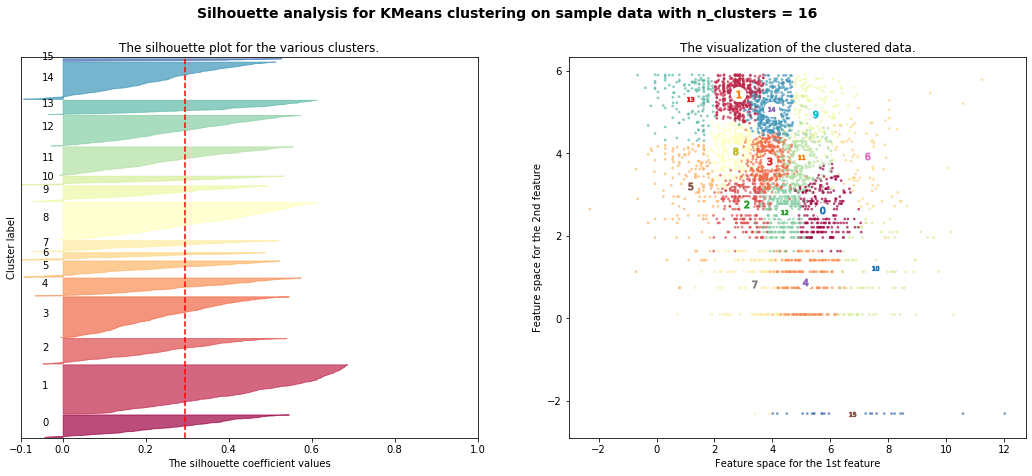

In [186]:
from __future__ import print_function
%matplotlib inline

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X=df.drop('labels',axis=1).values
y=df['labels'].values

range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15,16]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,n_init = 100,init='k-means++',random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    

In [61]:
from sklearn.cluster import AgglomerativeClustering 

In [62]:
model2 = AgglomerativeClustering(n_clusters=2, affinity='euclidean',  linkage='ward')

In [63]:
model2.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2)

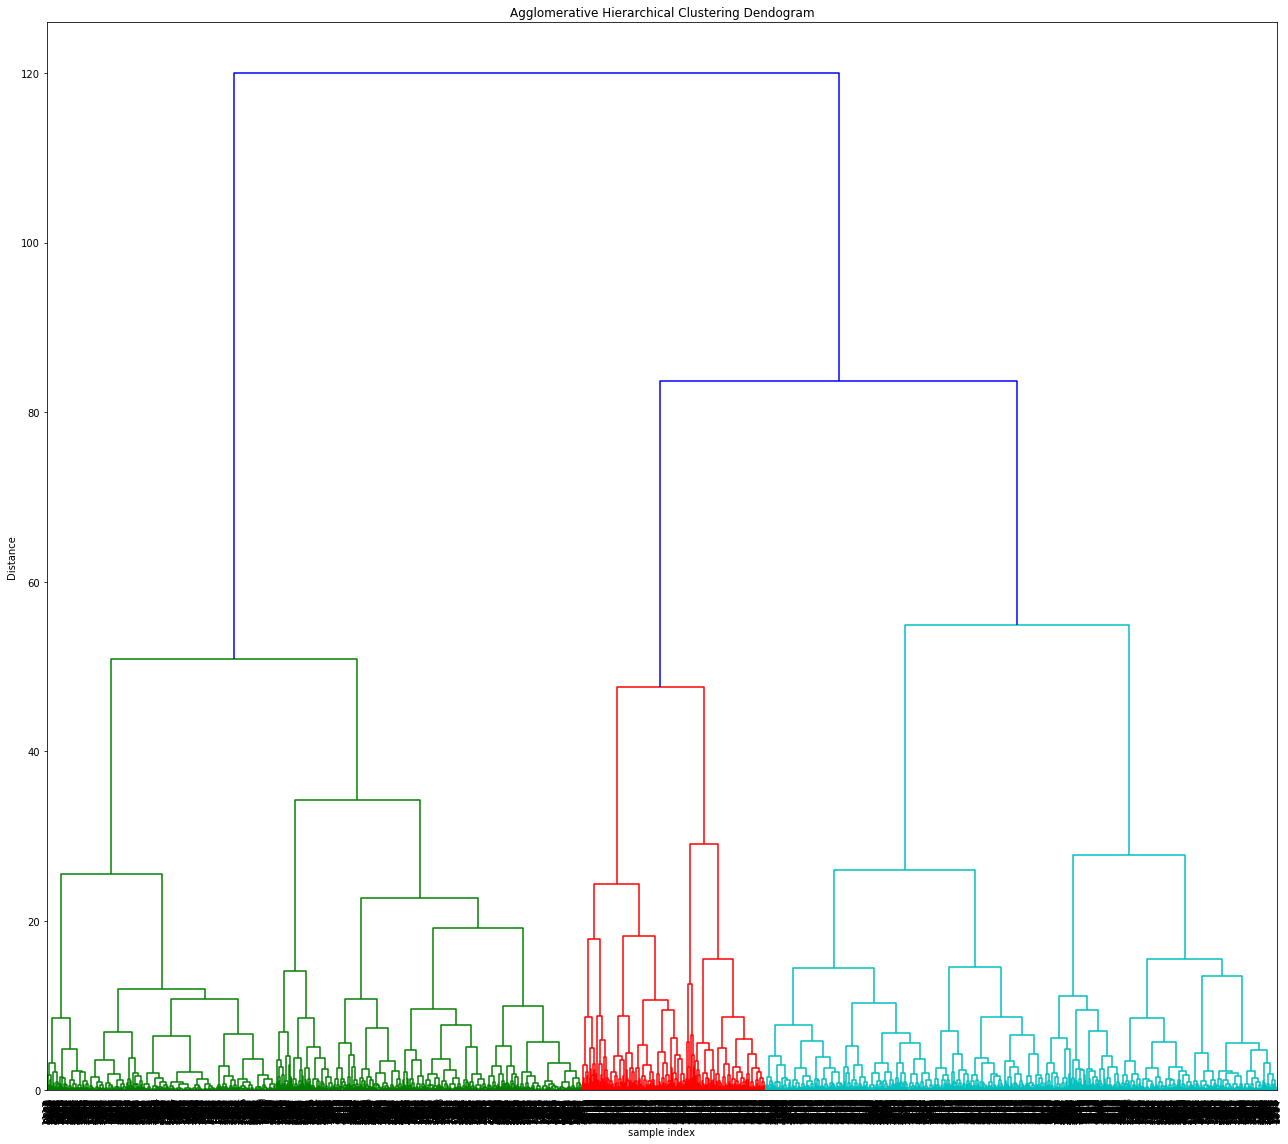

In [187]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
plt.figure(figsize=(18, 16))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
Z = linkage(X, 'ward')
dendrogram(Z,leaf_rotation=90.0,p=25,color_threshold=80,leaf_font_size=10,truncate_mode='level')
plt.tight_layout()

In [96]:
from sklearn.decomposition import PCA

In [99]:
#Applying PCA
X=log_data
pca=PCA(n_components=2)
X = pca.fit_transform(X)
pd.DataFrame(X)

0         1
0     3.340685  6.286441
1     4.138608 -0.444764
2     8.377478 -1.403395
3     2.333153 -1.432609
4     1.889310 -1.788723
...        ...       ...
3858 -2.047468  0.933663
3859 -2.821059 -0.384983
3860  0.818116 -1.484142
3861  2.530300 -1.594237
3862  0.380139  0.376852

[3863 rows x 2 columns]

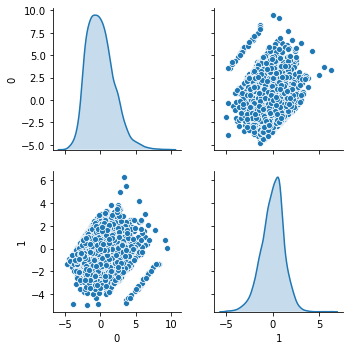

In [66]:
sns.pairplot(pd.DataFrame(X),diag_kind='kde')

In [100]:
pca.explained_variance_

array([3.67260104, 1.47155742])

In [101]:
3.67260104+1.47155742

5.14415846

In [102]:
3.67260104/5.14415846

0.7139362188310194

In [67]:
pca.explained_variance_ratio_

array([0.68012201, 0.27251492])

In [68]:
from sklearn.cluster import KMeans
# Let us check optimal number of clusters-
cluster_range = range( 1, 15)
cluster_errors = []
cluster_sil_scores = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 100,init='k-means++',random_state=0)
  clusters.fit(X)
  labels = clusters.labels_                     # capture the cluster lables
  centroids = clusters.cluster_centers_         # capture the centroids
  cluster_errors.append( clusters.inertia_ )    # capture the intertia
# combine the cluster_range and cluster_errors into a dataframe by combining them
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors} )
clusters_df[0:10]

num_clusters  cluster_errors
0             1    19866.739946
1             2    10753.718707
2             3     8120.194714
3             4     6403.508509
4             5     5383.973617
5             6     4550.166478
6             7     3921.064325
7             8     3521.667081
8             9     3167.105407
9            10     2849.028124

In [69]:
errors = clusters_df['cluster_errors']

In [70]:
for i in range(8):
    print(errors[i+1]-errors[i])

-9113.021239045476
-2633.523993078581
-1716.6862053627738
-1019.5348920672977
-833.8071384424466
-629.102153060684
-399.39724395418034
-354.56167414212314


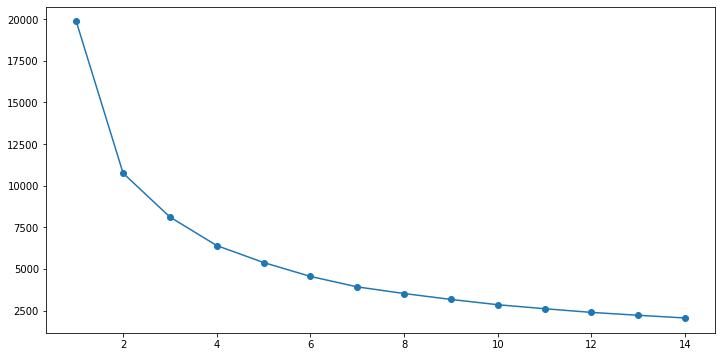

In [71]:
# Elbow plot

plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [72]:
# Number of clusters
kmeans = KMeans(n_clusters=2,n_init = 100,init='k-means++',random_state=0)
# Fitting the input data
kmeans = kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_
# Comparing with scikit-learn centroids
print("Centroid values")
print("sklearn")
print(centroids) # From sci-kit learn

Centroid values
sklearn
[[ 1.89237432 -0.02363004]
 [-1.24641572  0.01556397]]


In [73]:
colnames = ["PC1", "PC2"]
prediction= kmeans.predict(X)
#X["clusters"] = prediction
X_df = pd.DataFrame(X, columns= colnames)
X_df["group"] = prediction

In [74]:
X_df.head()

PC1       PC2  group
0  3.340685  6.286441      0
1  4.138608 -0.444764      0
2  8.377478 -1.403395      0
3  2.333153 -1.432609      0
4  1.889310 -1.788723      0

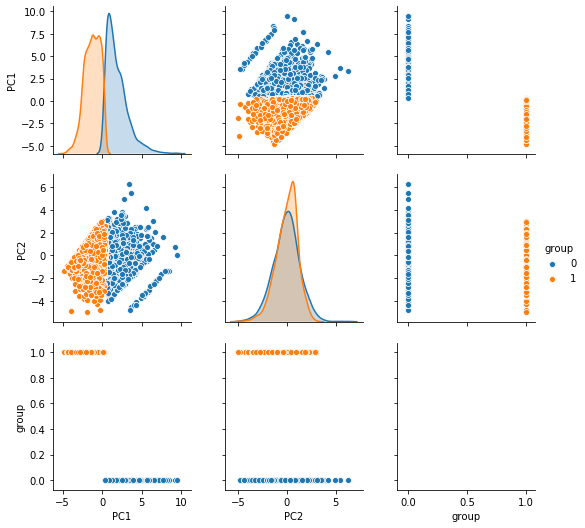

In [75]:
sns.pairplot(X_df,diag_kind='kde',hue='group')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000177C4ECE248>,
      dtype=object)

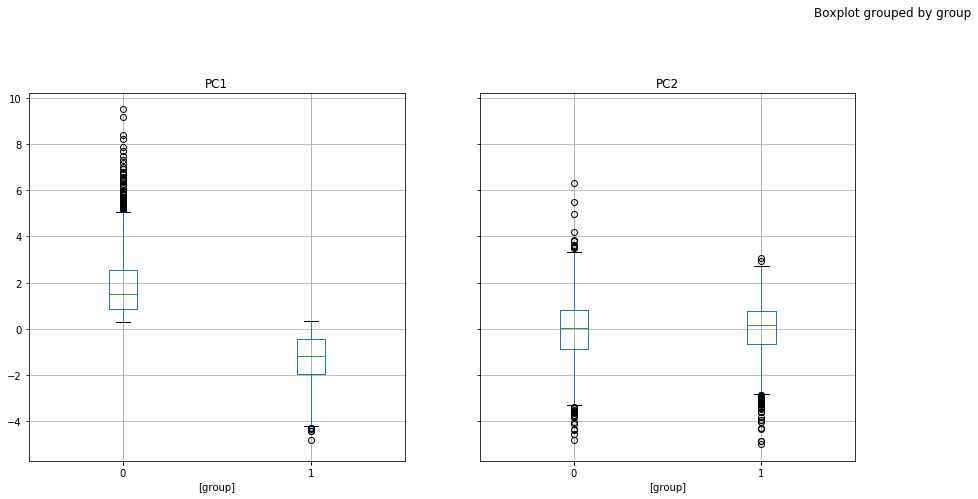

In [76]:
X_df.boxplot(by = 'group',layout=(2,4), figsize=(30, 15))

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.41133362017692066


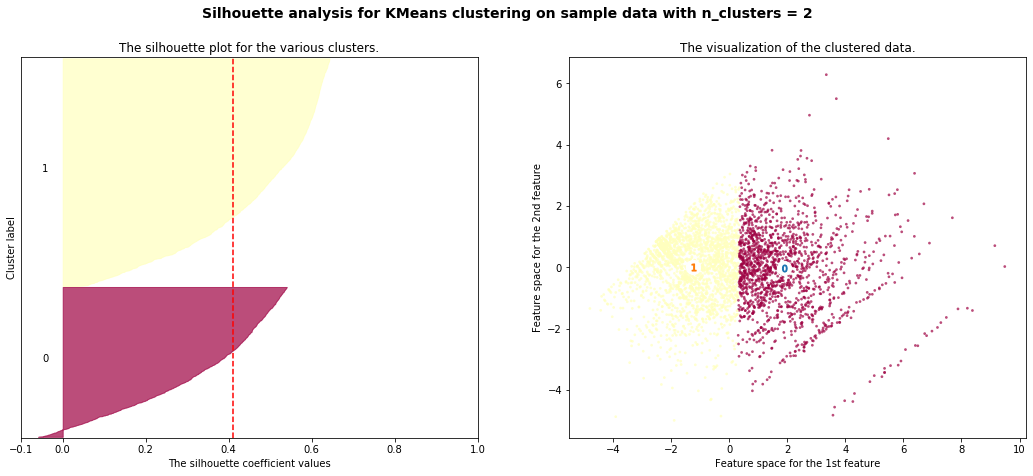

For n_clusters = 3 The average silhouette_score is : 0.3340573660513894


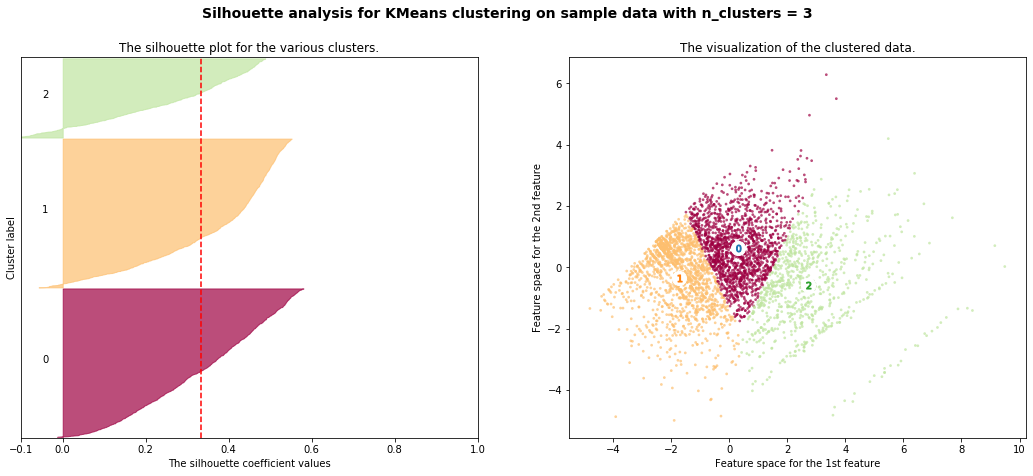

For n_clusters = 4 The average silhouette_score is : 0.34427522954758205


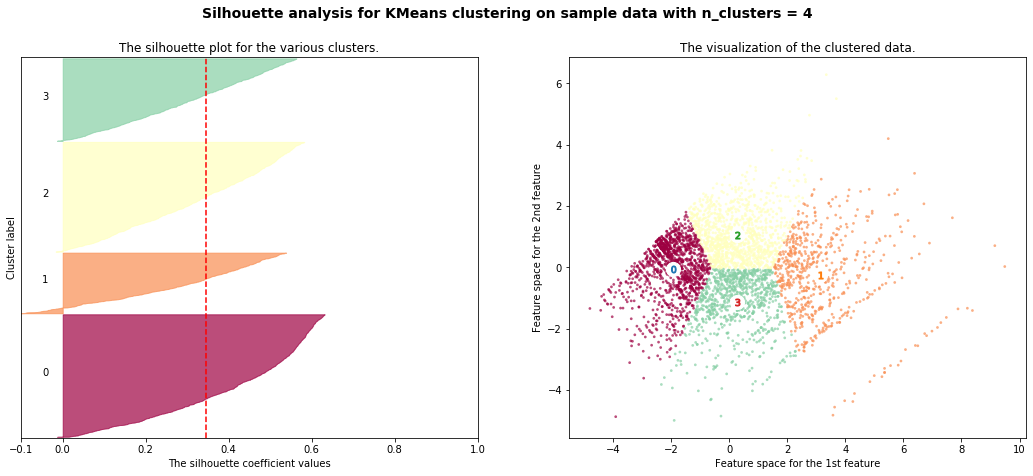

For n_clusters = 5 The average silhouette_score is : 0.32293759412796136


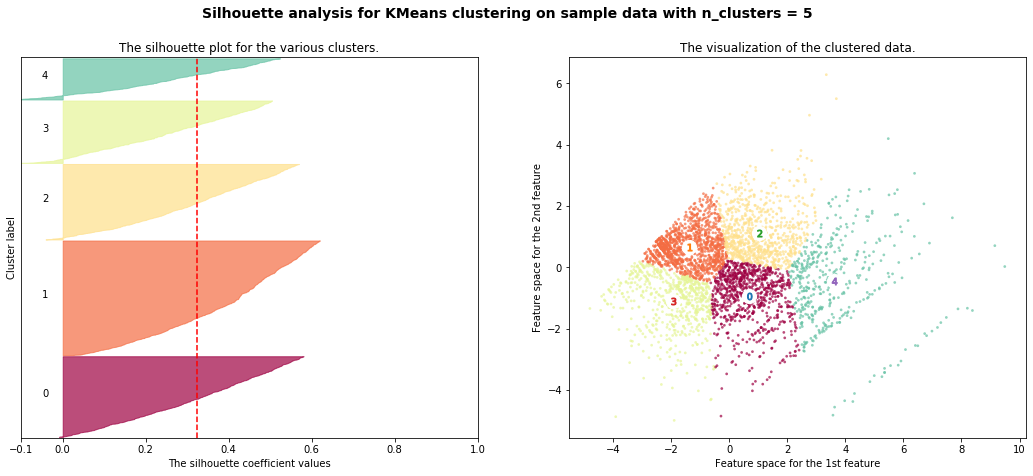

For n_clusters = 6 The average silhouette_score is : 0.3376078536154921


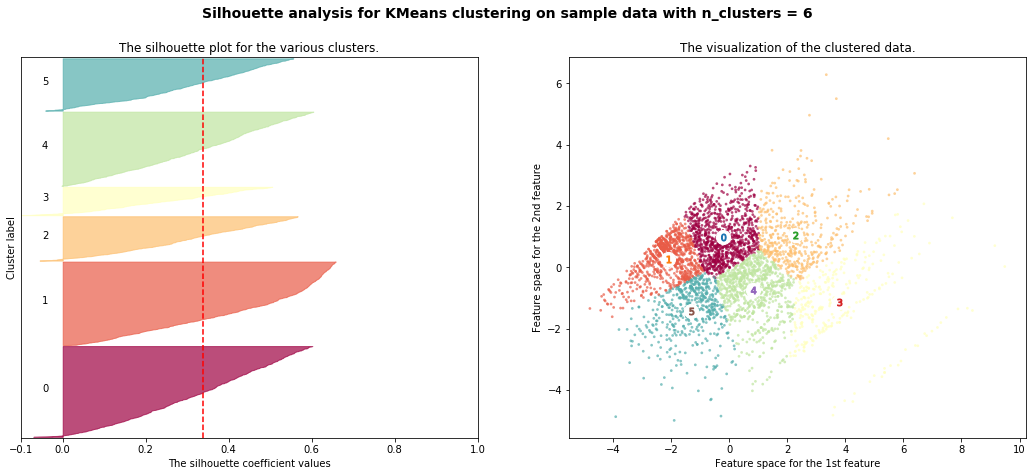

For n_clusters = 7 The average silhouette_score is : 0.3364071014995314


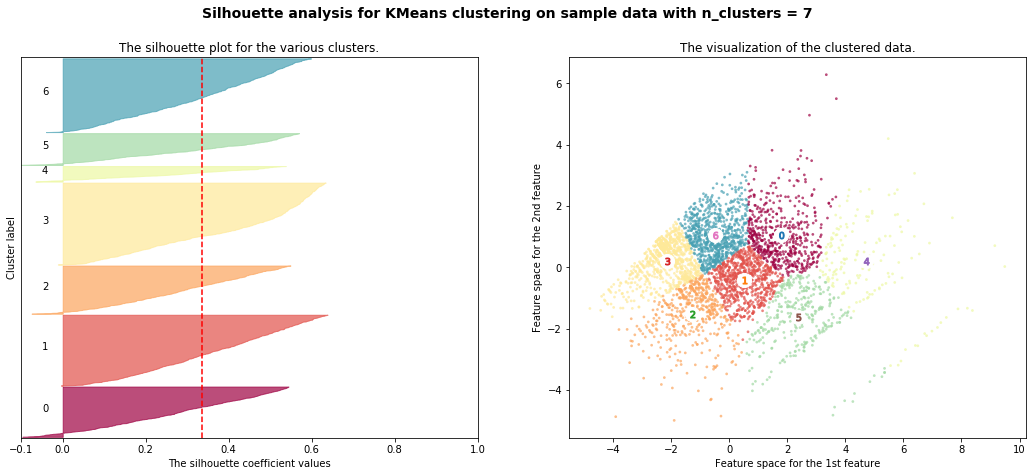

For n_clusters = 8 The average silhouette_score is : 0.3346736087739438


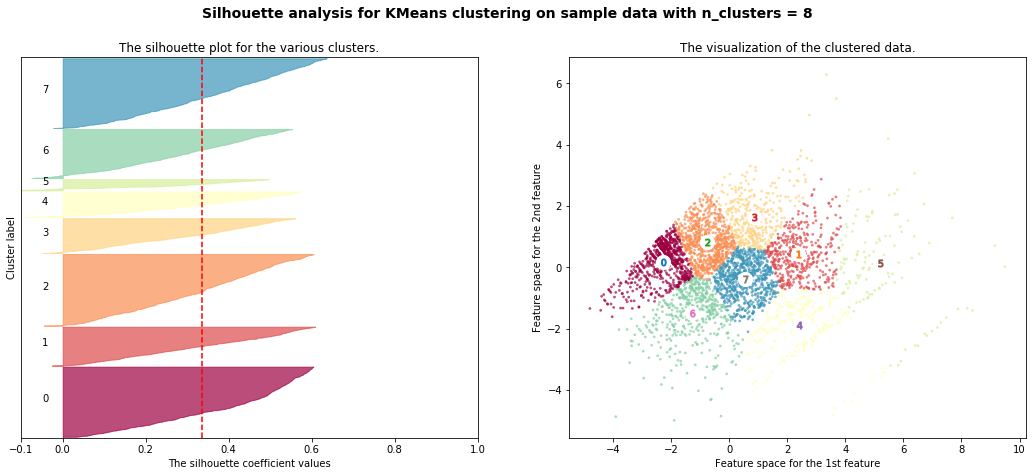

For n_clusters = 9 The average silhouette_score is : 0.3453747237288178


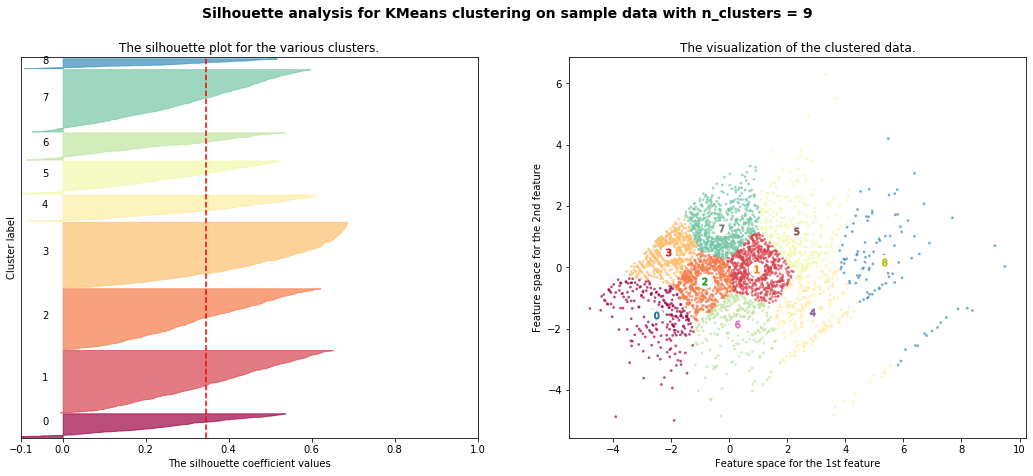

For n_clusters = 10 The average silhouette_score is : 0.35107202261908166


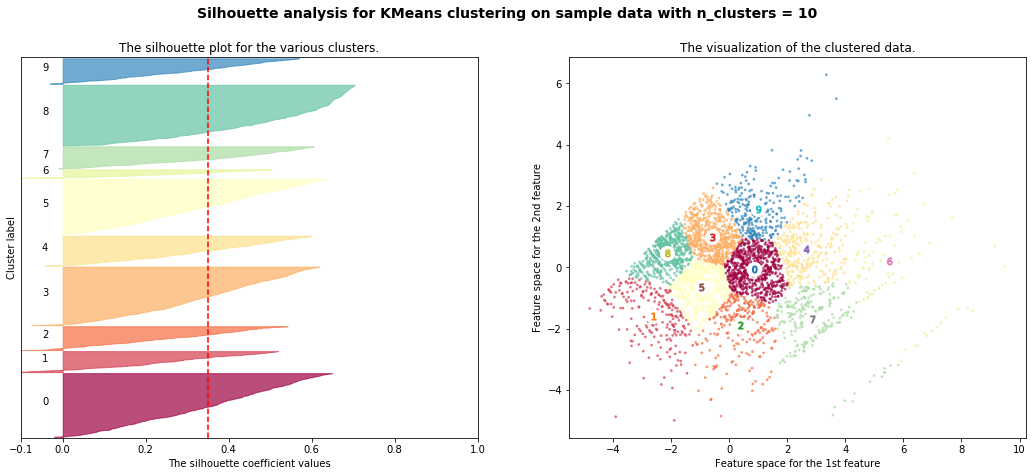

For n_clusters = 11 The average silhouette_score is : 0.3442077287627636


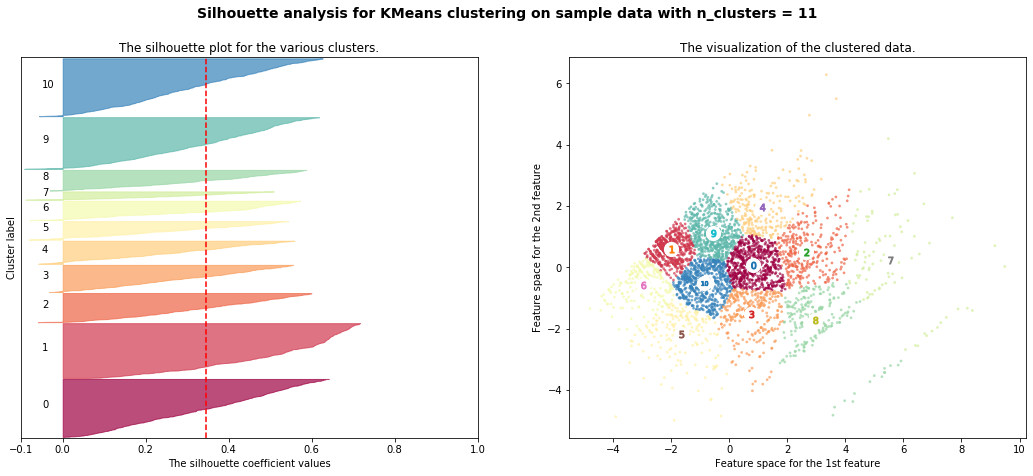

For n_clusters = 12 The average silhouette_score is : 0.34802869012892806


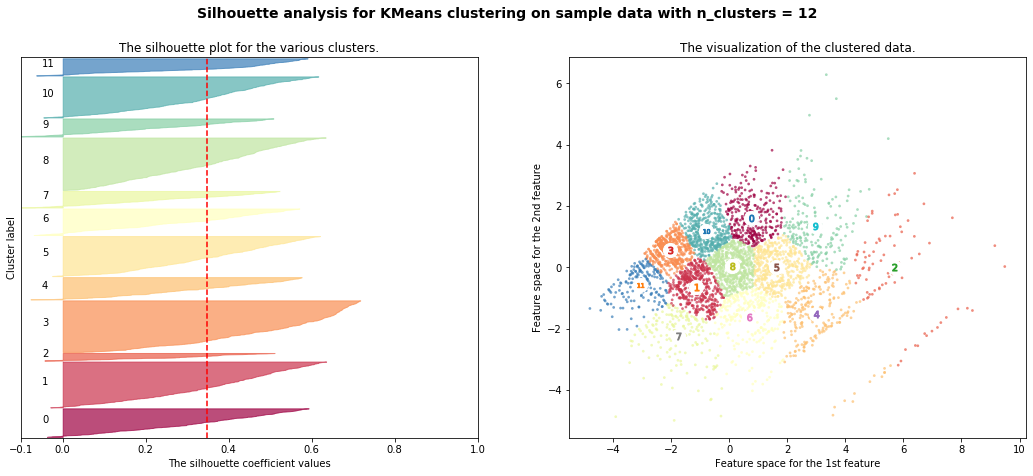

For n_clusters = 13 The average silhouette_score is : 0.34589402304175143


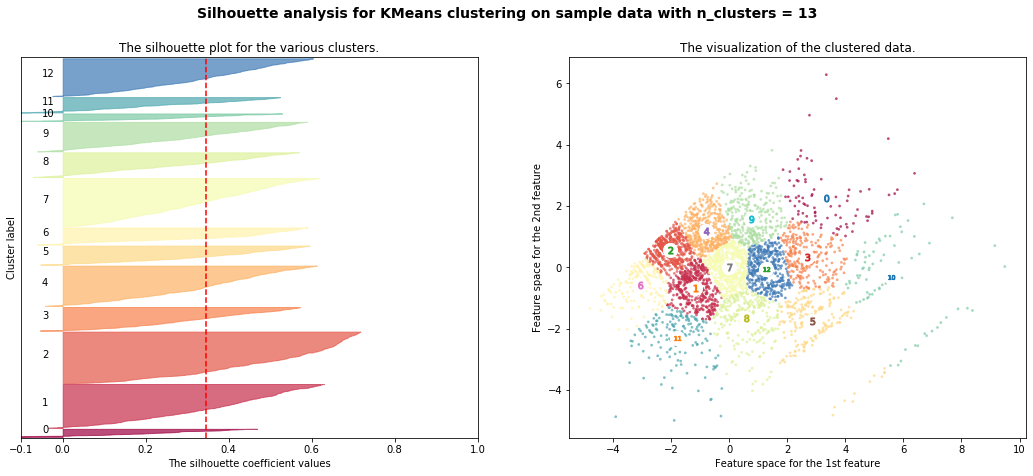

For n_clusters = 14 The average silhouette_score is : 0.35096012749396005


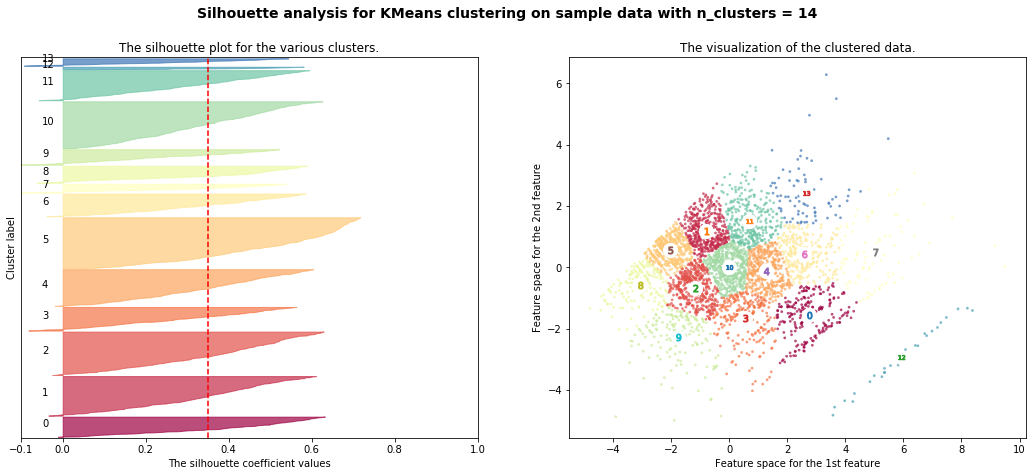

For n_clusters = 15 The average silhouette_score is : 0.3563313850541693


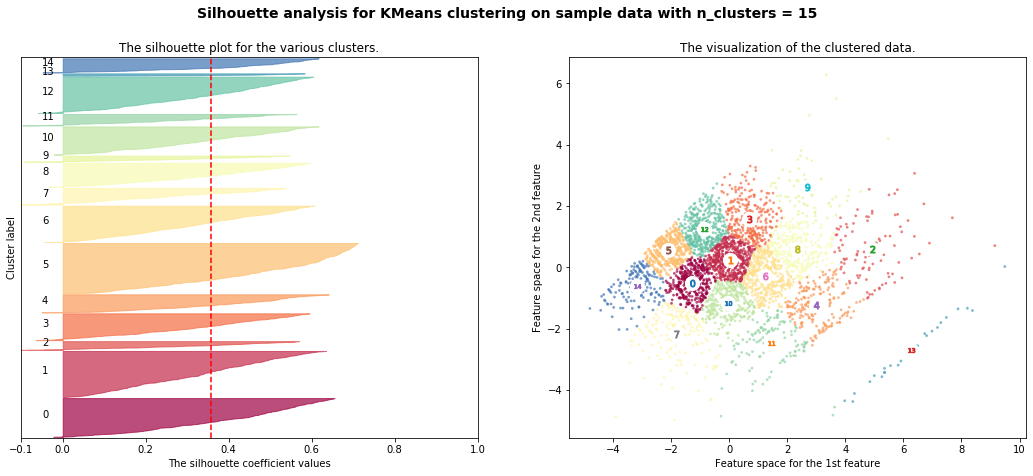

For n_clusters = 16 The average silhouette_score is : 0.3545716578739325


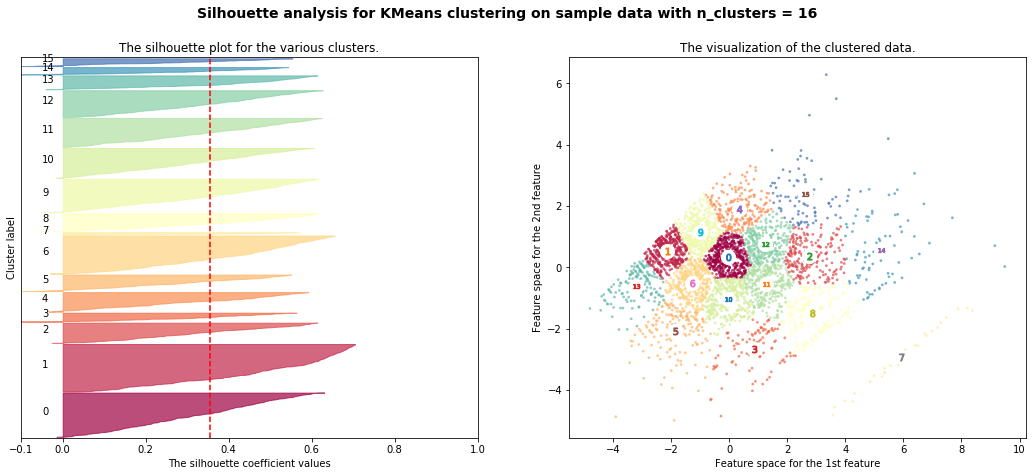

In [77]:
from __future__ import print_function
%matplotlib inline

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X=X_df.drop('group',axis=1).values
y=X_df['group'].values

range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15,16]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,n_init = 100,init='k-means++',random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [78]:
from sklearn.cluster import AgglomerativeClustering 

In [79]:
model2 = AgglomerativeClustering(n_clusters=2, affinity='euclidean',  linkage='ward')

In [80]:
model2.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2)

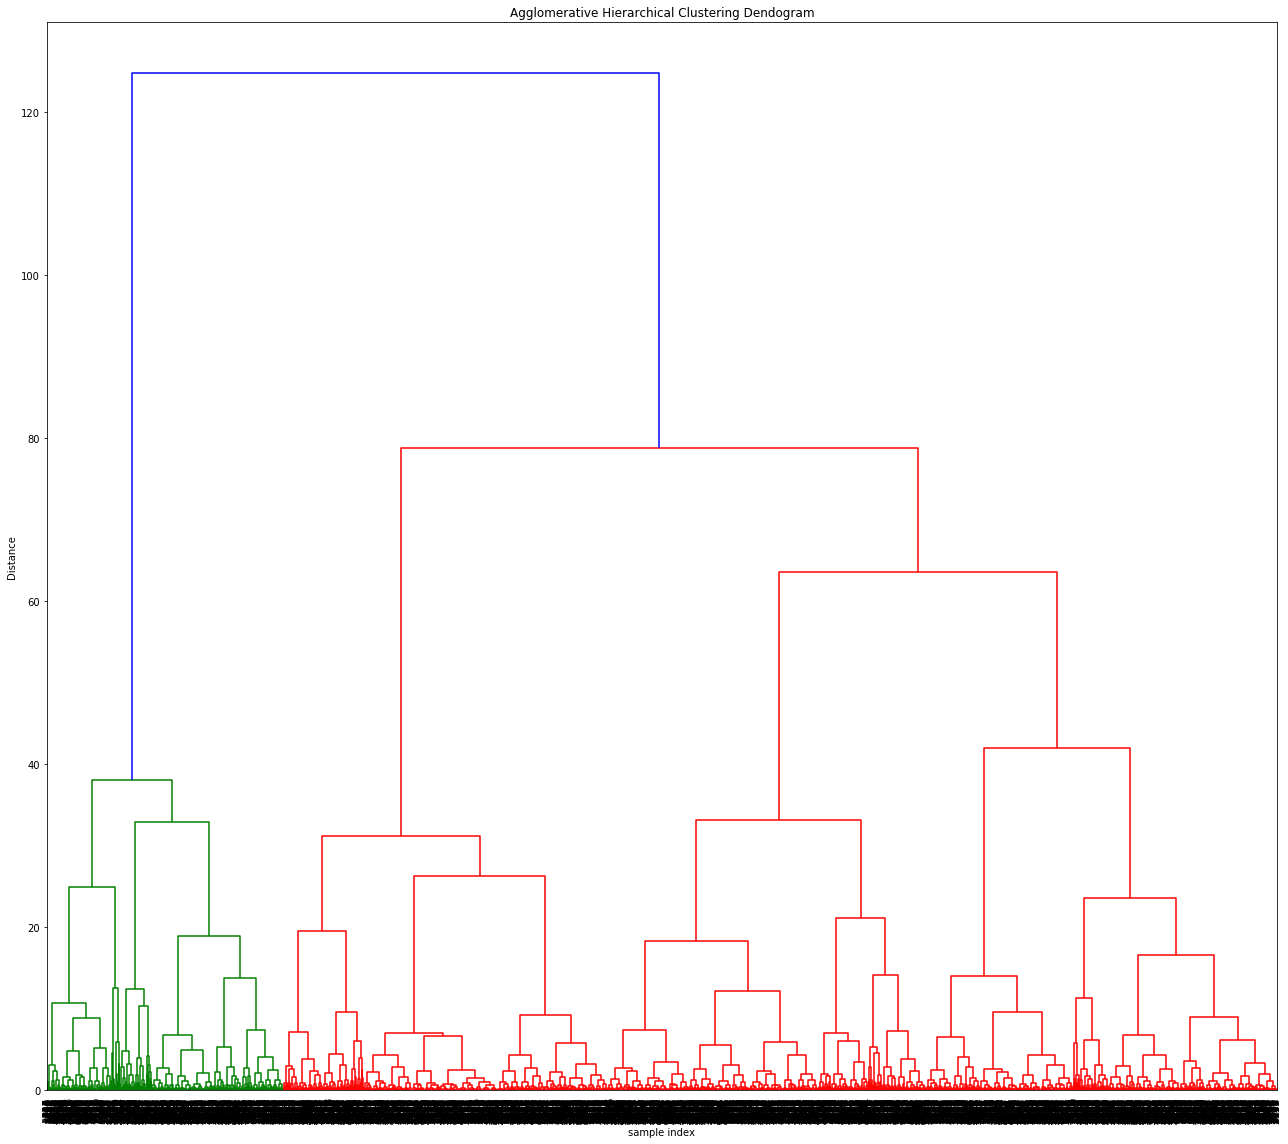

In [81]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
plt.figure(figsize=(18, 16))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
Z = linkage(X, 'ward')
dendrogram(Z,leaf_rotation=90.0,p=25,color_threshold=80,leaf_font_size=10,truncate_mode='level')
plt.tight_layout()

In [190]:
#Applying PCA
X=log_data
pca=PCA(n_components=1)
X = pca.fit_transform(X)
X

array([[3.38528757],
       [4.17457023],
       [8.32613407],
       ...,
       [0.92493218],
       [2.60281808],
       [0.49549054]])

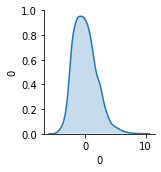

In [83]:
sns.pairplot(pd.DataFrame(X),diag_kind='kde')

In [84]:
pca.explained_variance_ratio_

array([0.68012201])

In [85]:
from sklearn.cluster import KMeans
# Let us check optimal number of clusters-
cluster_range = range( 1, 15)
cluster_errors = []
cluster_sil_scores = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 100,init='k-means++',random_state=0)
  clusters.fit(X)
  labels = clusters.labels_                     # capture the cluster lables
  centroids = clusters.cluster_centers_         # capture the centroids
  cluster_errors.append( clusters.inertia_ )    # capture the intertia
# combine the cluster_range and cluster_errors into a dataframe by combining them
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors} )
clusters_df[0:10]

num_clusters  cluster_errors
0             1    14183.585200
1             2     5071.458881
2             3     2606.580615
3             4     1687.455508
4             5     1114.030299
5             6      804.422674
6             7      631.548161
7             8      490.344121
8             9      382.811857
9            10      320.383789

In [86]:
errors = clusters_df['cluster_errors']

In [87]:
for i in range(8):
    print(errors[i+1]-errors[i])

-9112.126319162764
-2464.878265872355
-919.1251072574269
-573.4252084071488
-309.60762573357215
-172.8745122683199
-141.20404085062353
-107.5322634988255


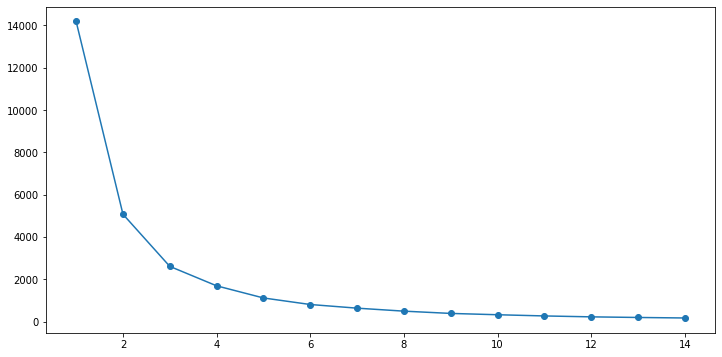

In [88]:
# Elbow plot
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [89]:
# Number of clusters
kmeans = KMeans(n_clusters=3,n_init = 100,init='k-means++',random_state=0)
# Fitting the input data
kmeans = kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_
# Comparing with scikit-learn centroids
print("Centroid values")
print("sklearn")
print(centroids) # From sci-kit learn

Centroid values
sklearn
[[ 0.4305957 ]
 [ 3.0890844 ]
 [-1.76730987]]


In [90]:
colnames = ["PC1"]
prediction= kmeans.predict(X)
#X["clusters"] = prediction
X_df = pd.DataFrame(X, columns= colnames)
X_df["group"] = prediction

In [91]:
X_df.shape

(3863, 2)

In [106]:
log_data

Monetary   Recency  Frequency
CustomerID                                
12346.0     11.253944  5.784133   0.000000
12747.0      6.490708  0.741937   2.302585
12748.0      8.226662 -2.302585   5.278115
12749.0      4.589549  1.131402   1.609438
12820.0      4.065602  1.131402   1.386294
...               ...       ...        ...
18280.0      3.169686  5.624378   0.000000
18281.0      1.637053  5.193512   0.000000
18282.0      3.646755  1.960095   0.693147
18283.0      4.202451  1.131402   2.772589
18287.0      4.388257  3.740048   1.098612

[3863 rows x 3 columns]

In [107]:
log_data1=log_data.reset_index('CustomerID')
log_data1

CustomerID   Monetary   Recency  Frequency
0        12346.0  11.253944  5.784133   0.000000
1        12747.0   6.490708  0.741937   2.302585
2        12748.0   8.226662 -2.302585   5.278115
3        12749.0   4.589549  1.131402   1.609438
4        12820.0   4.065602  1.131402   1.386294
...          ...        ...       ...        ...
3858     18280.0   3.169686  5.624378   0.000000
3859     18281.0   1.637053  5.193512   0.000000
3860     18282.0   3.646755  1.960095   0.693147
3861     18283.0   4.202451  1.131402   2.772589
3862     18287.0   4.388257  3.740048   1.098612

[3863 rows x 4 columns]

In [108]:
X_df

PC1  group
0     3.340685      1
1     4.138608      1
2     8.377478      1
3     2.333153      1
4     1.889310      1
...        ...    ...
3858 -2.047468      2
3859 -2.821059      2
3860  0.818116      0
3861  2.530300      1
3862  0.380139      0

[3863 rows x 2 columns]

In [112]:
finaldf=log_data1.join(X_df)
finaldf

CustomerID   Monetary   Recency  Frequency       PC1  group
0        12346.0  11.253944  5.784133   0.000000  3.340685      1
1        12747.0   6.490708  0.741937   2.302585  4.138608      1
2        12748.0   8.226662 -2.302585   5.278115  8.377478      1
3        12749.0   4.589549  1.131402   1.609438  2.333153      1
4        12820.0   4.065602  1.131402   1.386294  1.889310      1
...          ...        ...       ...        ...       ...    ...
3858     18280.0   3.169686  5.624378   0.000000 -2.047468      2
3859     18281.0   1.637053  5.193512   0.000000 -2.821059      2
3860     18282.0   3.646755  1.960095   0.693147  0.818116      0
3861     18283.0   4.202451  1.131402   2.772589  2.530300      1
3862     18287.0   4.388257  3.740048   1.098612  0.380139      0

[3863 rows x 6 columns]

In [117]:
labels=finaldf.groupby('group')
df0=labels.get_group(0)
df1=labels.get_group(1)
df2=labels.get_group(2)
finaldf1=pd.concat([df0,df1,df2])
finaldf1

CustomerID  Monetary   Recency  Frequency       PC1  group
10       12827.0  4.434500  1.629241   1.098612  1.717850      0
15       12832.0  2.995732  3.468856   0.693147 -0.557485      0
18       12836.0  3.372455  4.079231   1.386294 -0.405484      0
22       12840.0  4.932313  4.963544   1.386294  0.105959      0
25       12843.0  4.814620  4.175925   2.079442  0.787567      0
...          ...       ...       ...        ...       ...    ...
3854     18274.0  2.714695  3.404525   0.000000 -0.982474      2
3856     18277.0  2.887590  4.062166   0.000000 -1.272122      2
3857     18278.0  2.839078  4.291828   0.000000 -1.447180      2
3858     18280.0  3.169686  5.624378   0.000000 -2.047468      2
3859     18281.0  1.637053  5.193512   0.000000 -2.821059      2

[3863 rows x 6 columns]

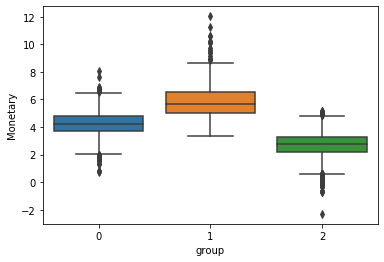

In [122]:
sns.boxplot(finaldf1['group'],finaldf1['Monetary'])

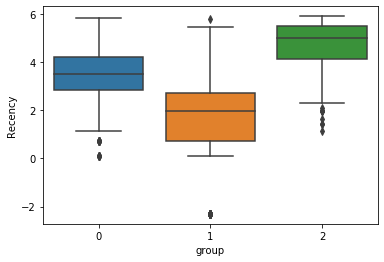

In [124]:
sns.boxplot(finaldf1['group'],finaldf1['Recency'])

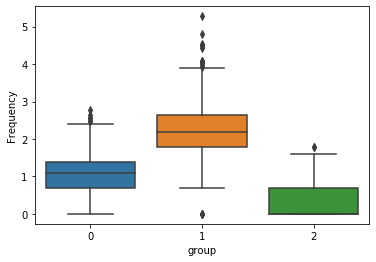

In [125]:
sns.boxplot(finaldf1['group'],finaldf1['Frequency'])

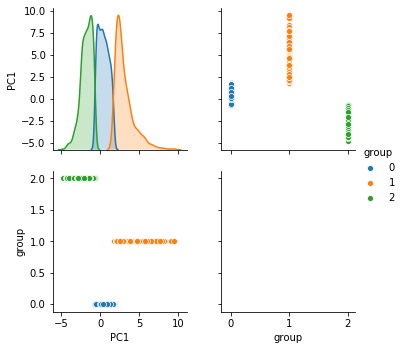

In [94]:
sns.pairplot(X_df,diag_kind='kde',hue='group')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000177CE96A108>,
      dtype=object)

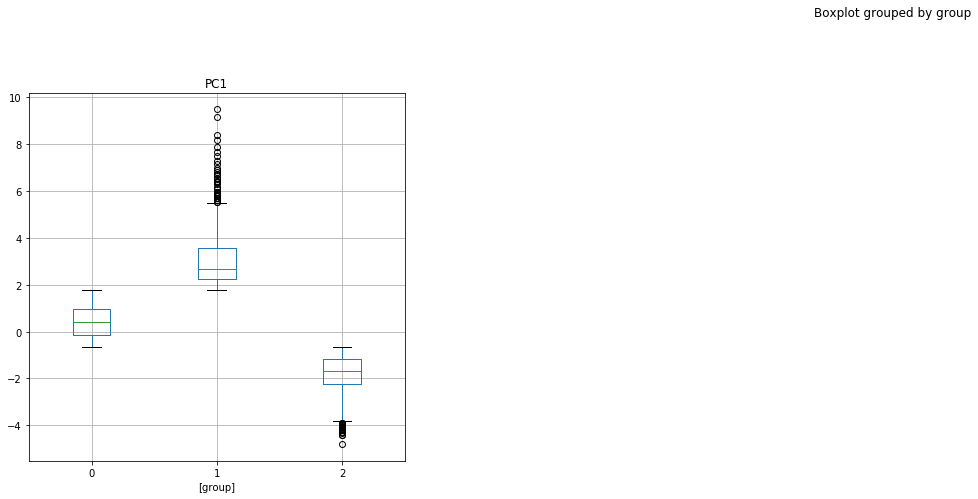

In [95]:
X_df.boxplot(by = 'group',layout=(2,4), figsize=(30, 15))

In [96]:
from __future__ import print_function
%matplotlib inline

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X=X_df.drop('group',axis=1).values
y=X_df['group'].values

range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15,16]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters,n_init = 100,init='k-means++',random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)




Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.5720751712994758
For n_clusters = 3 The average silhouette_score is : 0.554193681537974
For n_clusters = 4 The average silhouette_score is : 0.5262438054291716
For n_clusters = 5 The average silhouette_score is : 0.5343490152886184
For n_clusters = 6 The average silhouette_score is : 0.5269717133665037
For n_clusters = 7 The average silhouette_score is : 0.5128137787173128
For n_clusters = 8 The average silhouette_score is : 0.5246752065656195
For n_clusters = 9 The average silhouette_score is : 0.5332728971654527
For n_clusters = 10 The average silhouette_score is : 0.5317219366656638
For n_clusters = 11 The average silhouette_score is : 0.5278376157161087
For n_clusters = 12 The average silhouette_score is : 0.5295729998056821
For n_clusters = 13 The average silhouette_score is : 0.524981119304621
For n_clusters = 14 The average silhouette_score is : 0.5237337029382

In [97]:
from sklearn.cluster import AgglomerativeClustering 

In [98]:
model2 = AgglomerativeClustering(n_clusters=2, affinity='euclidean',  linkage='ward')

In [99]:
model2.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2)

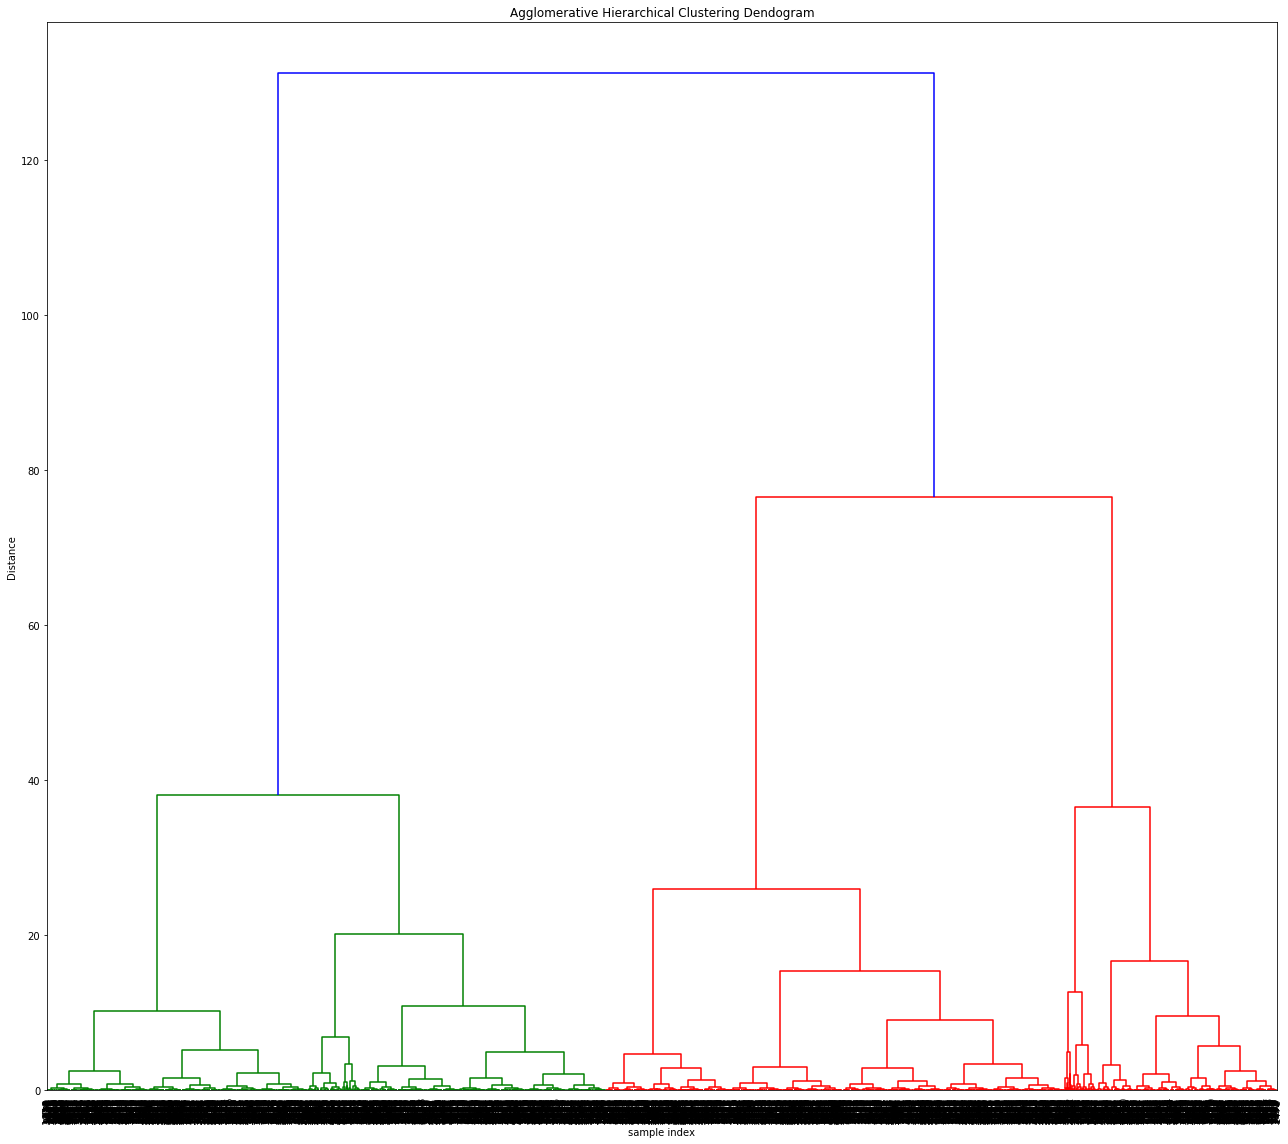

In [100]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
plt.figure(figsize=(18, 16))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
Z = linkage(X, 'ward')
dendrogram(Z,leaf_rotation=90.0,p=25,color_threshold=80,leaf_font_size=10,truncate_mode='level')
plt.tight_layout()

The **best silhouette score** obtained is when the **number of clusters is 2**.

**Conclusion - Perspective after applying k-means clustering**:

Unfortunately, we didn't obtain a clearly separated clusters. Clusters assignments are muddled. (It may be due to outliers who weren't removed).

Limitations of k-means clustering:
- There is no assurance that it will lead to the ***global*** best solution.
- Can't deal with **different shapes**(not circular) and consider one point's probability of belonging to more than one cluster.

These disadvantages of k-means mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope. Here comes Guassian Mixture Model (GMM) in help by providing greater flexibility due to clusters having unconstrained covariances and allowing probabilistic cluster assignment.

Reference  ***Python Data Science Handbook*** by ***Jake VanderPlas***.

**Note- Further Explanation:** A common practice before doing clustering: **Principal Component Analysis (PCA)**. PCA calculates the dimensions which best maximize variance.It gives directions on how many components to consider for GMM. Basically, it does **dimensionality reduction** while keeping the most important features, characteristics (combinations of features best describe customers). But as we are not dealing with high dimension we won't do it for this case.

### Conclusion - Perspectives

At this juncture, it makes sense to show interested stakeholders the cluster solutions and get their input. The decision should be based upon how the business plans to use the results, and the **level of granularity** they want to see in the clusters. What range of customer behavior from high-to-low value customers are the business stakeholders interested in exploring? And from the answer to that question various methods of clustering can be further exploited whether applied on RFM variables or directly on the transaction dataset available.

If I have more time, I will do Classification for future customers in appropriate defined clusters by trying different models like SVC, Logistic Regression on training set and compare their performance on the test set in order to choose the best one to use for our predictions.